# 0. Meta

## 0.1. Packages

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from plz_plot.core import plot_plz_data
from plz_plot.io import get_plz_dataframe, load_plz_records
import matplotlib.pyplot as plt
from cartopy import feature
from cartopy import crs
from shapely.geometry import MultiPolygon, MultiLineString, box
from shapely.ops import unary_union
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
import cartopy.io.shapereader as shpreader

## 0.2. Functions

In [169]:
# Funktion, um Werte in Float zu konvertieren und Fehler abzufangen
def convert_to_float(value):
    try:
        return float(value)
    except ValueError:
        print(f"Konvertierungsfehler bei: {value}")
        return None

# 1. Data import

In [170]:
file_path = r"C:\Sync\03_projects\data_science\projects\weddingsurvey\Hochzeitsgäste_im_Check.csv"

In [171]:
df = pd.read_csv(file_path)

In [172]:
df.head()

,Teilnehmer,Startzeit,Endzeit,Quelle,Wie alt bist du?,Mit welchem Geschlecht identifizierst du dich?,In welchem Land bist du geboren?,Wie lautet die Postleitzahl (PLZ) deines Wohnortes?,Wie ist dein Familienstand?,Wie viele Kinder hast du?,...,Wer fährt besser Fahrrad nach dem Biergartenbesuch? (Lucas),Wer hat mehr Narben? (Lena),Wer hat mehr Narben? (Lucas),Wer hat nach einem Tag in der Sonne eher die Hautfarbe eines Hummers? (Lena),Wer hat nach einem Tag in der Sonne eher die Hautfarbe eines Hummers? (Lucas),"Welchen Nachnamen soll das Brautpaar wählen, wenn es nach dir geht?",Wer verbringt mehr Zeit am Handy? (Lena),Wer verbringt mehr Zeit am Handy? (Lucas),Wer ist romantischer? (Lena),Wer ist romantischer? (Lucas)
0,1,05.08.2024 08:00:04,05.08.2024 08:03:20,Direkter Link,57,Frau,DE,67435,Verheiratet,5,...,übersprungen,0,1,1,1,Beide sollen ihren aktuellen Nachnamen behalten,1,0,0,1
1,2,05.08.2024 15:03:31,05.08.2024 15:06:48,Direkter Link,34,Mann,Deutschland,67434,Liiert,0,...,1,1,0,1,0,Wallbert-Almann,1,1,0,1
2,3,06.08.2024 13:10:35,06.08.2024 13:16:05,Direkter Link,30,Mann,Deutschland,20099,Liiert,0,...,0,0,1,1,0,Albert-Wallmann,1,0,1,0
3,4,06.08.2024 14:03:29,06.08.2024 14:08:22,Direkter Link,28,Frau,Deutschland,64293,Verheiratet,2,...,1,0,1,1,0,Almann-Wallbert,1,0,0,1
4,5,06.08.2024 14:29:37,06.08.2024 14:38:57,Direkter Link,31,Mann,Deutschland,64293,Verheiratet,2,...,1,0,1,1,0,Albert-Wallmann,1,0,0,1


# 2. Offene Fragen

## Wie alt bist du?

In [173]:
df['Wie alt bist du? (float)'] = df['Wie alt bist du?'].apply(convert_to_float)
invalid_entries = df[df['Wie alt bist du? (float)'].isnull()]['Wie alt bist du?']
invalid_entries

Konvertierungsfehler bei: Too good to go
Konvertierungsfehler bei: 78 Jahre 


11    Too good to go
46         78 Jahre 
Name: Wie alt bist du?, dtype: object

In [174]:
# Ersetze den ersten ungültigen Eintrag mit NaN
df.loc[invalid_entries.index[0], 'Wie alt bist du?'] = np.nan

# Ersetze den zweiten ungültigen Eintrag mit 78
df.loc[invalid_entries.index[1], 'Wie alt bist du?'] = 78

In [175]:
# Konvertierung in float vornehmen
df['Wie alt bist du? (float)'] = df['Wie alt bist du?'].apply(convert_to_float)

# Überprüfen, ob die Änderungen korrekt sind
df[['Wie alt bist du?', 'Wie alt bist du? (float)']].loc[invalid_entries.index]

,Wie alt bist du?,Wie alt bist du? (float)
11,NaN,NaN
46,78,78.0


In [176]:
# Berechnung der statistischen Kennzahlen für die Altersvariable
summary_stats = {
    'Min': df['Wie alt bist du? (float)'].min(),
    'Max': df['Wie alt bist du? (float)'].max(),
    'Mean': df['Wie alt bist du? (float)'].mean(),
    'SD': df['Wie alt bist du? (float)'].std()
}

print("Zusammenfassung der Altersdaten:")
summary_stats

Zusammenfassung der Altersdaten:


{'Min': np.float64(21.0),
 'Max': np.float64(80.0),
 'Mean': np.float64(36.224489795918366),
 'SD': np.float64(13.50503811256261)}

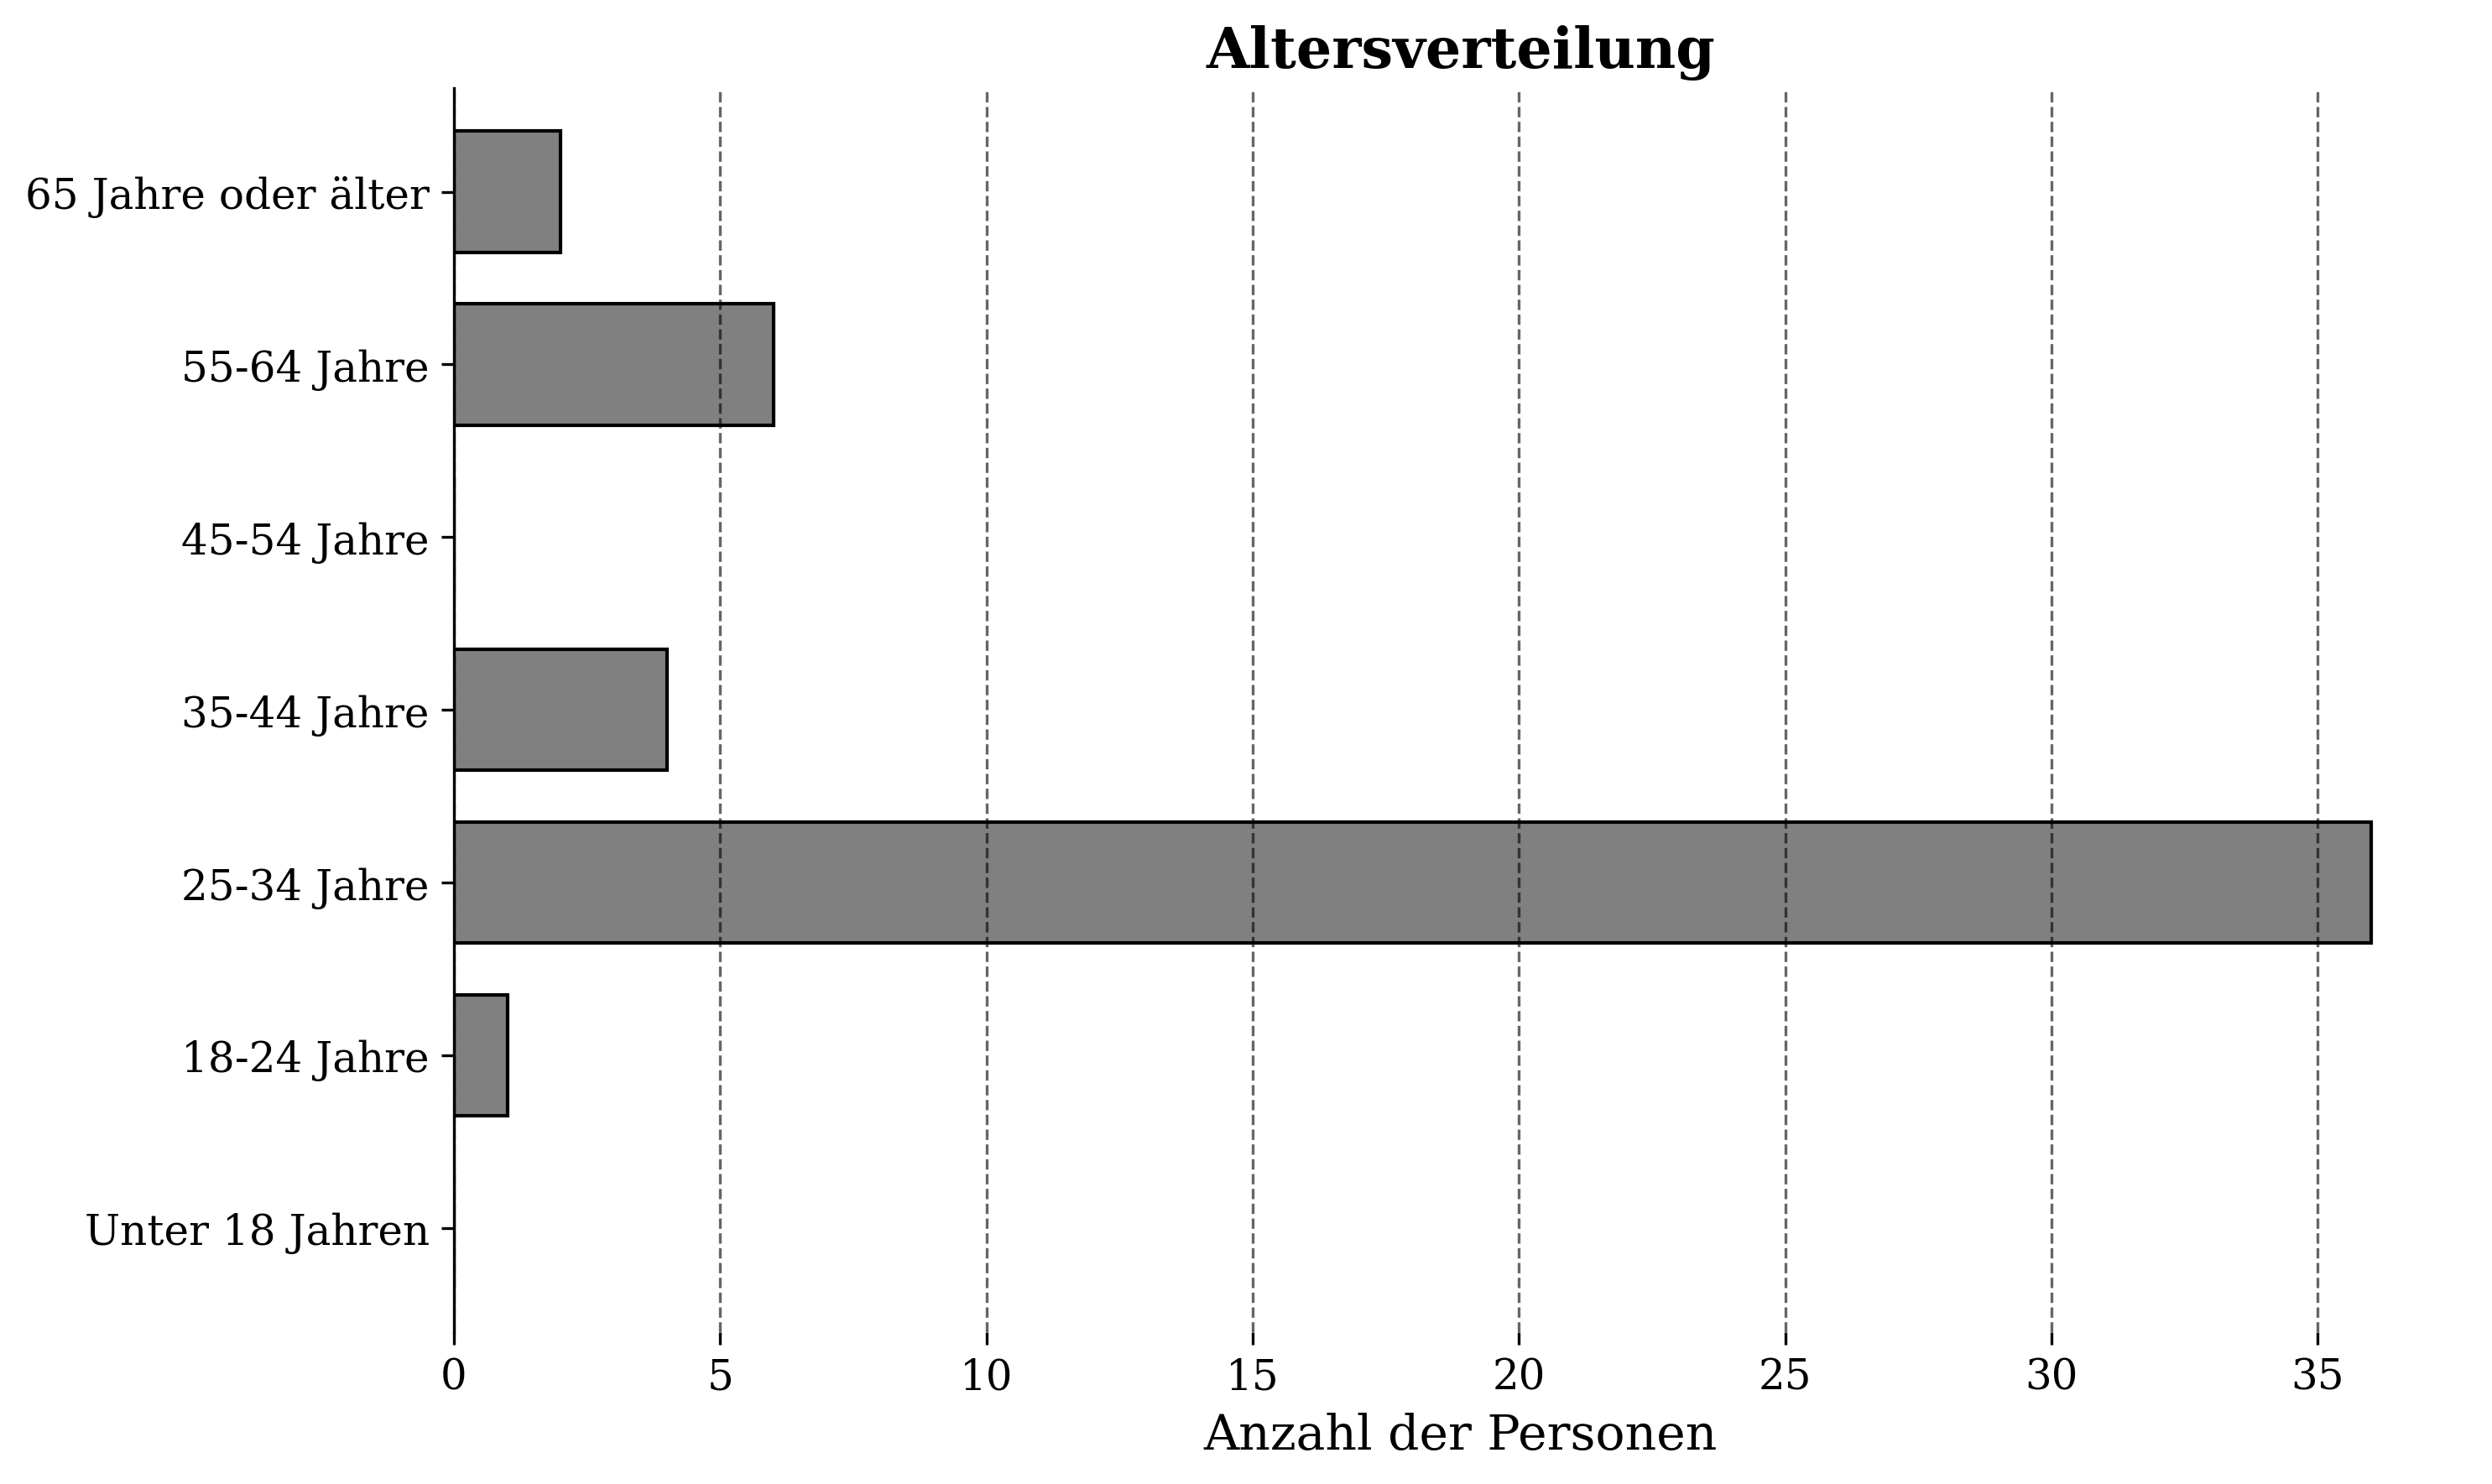

In [177]:
# Definiere die Bins und Labels für die Altersgruppen
bins = [0, 18, 25, 35, 45, 55, 65, float('inf')]
labels = ['Unter 18 Jahren', '18-24 Jahre', '25-34 Jahre', '35-44 Jahre', '45-54 Jahre', '55-64 Jahre', '65 Jahre oder älter']

# Verwende pd.cut, um die Altersgruppen ohne neue Spalte zu erstellen und direkt zu zählen
age_group_counts = pd.cut(df['Wie alt bist du? (float)'], bins=bins, labels=labels, right=False).value_counts(sort=False)

# Erstelle das horizontale Balkendiagramm der Altersgruppen
plt.figure(figsize=(10, 6), dpi=300)
age_group_counts = pd.cut(df['Wie alt bist du? (float)'], bins=bins, labels=labels, right=False).value_counts(sort=False)
age_group_counts.plot(kind='barh', color='gray', edgecolor='black', width=0.7)  # Verkleinere den Abstand zwischen den Balken durch Setzen der Breite
plt.title('Altersverteilung', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Anzahl der Personen', fontsize=14, family='serif')
plt.xticks(fontsize=12, family='serif')
plt.yticks(fontsize=12, family='serif')
plt.grid(axis='x', linestyle='--', alpha=0.6, color='black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.ylabel('')  # Entfernt das y-Label
plt.tight_layout()  # Optimiert den Layout-Abstand
plt.show()

## In welchem Land bist du geboren?

In [179]:
# Berechnung der Häufigkeit der Antworten auf die offene Frage
country_counts = df['In welchem Land bist du geboren?'].value_counts()

# Anzeigen der Einträge und ihrer Häufigkeiten
print(country_counts)

In welchem Land bist du geboren?
Deutschland     25
Deutschland     17
DE               1
Sauerland        1
Bangladesch      1
Pfalz            1
Russland         1
Afghanistan      1
Germany          1
DE               1
Name: count, dtype: int64


In [180]:
# Entferne führende und nachfolgende Leerzeichen in der Spalte
df['In welchem Land bist du geboren?'] = df['In welchem Land bist du geboren?'].str.strip()

# Definiere die Einträge, die zusammengeführt werden sollen
to_merge = ["Deutschland", "DE", "Sauerland", "Pfalz", "Germany"]

# Ersetze diese Einträge durch "Deutschland"
df['In welchem Land bist du geboren?'] = df['In welchem Land bist du geboren?'].replace(to_merge, "Deutschland")

# Überprüfe das Ergebnis der Zusammenführung
country_counts = df['In welchem Land bist du geboren?'].value_counts()
print(country_counts)

In welchem Land bist du geboren?
Deutschland    47
Bangladesch     1
Russland        1
Afghanistan     1
Name: count, dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5700\3119641532.py:35: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5700\3119641532.py:35: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5700\3119641532.py:35: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5700\3119641532.py:35: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS befor

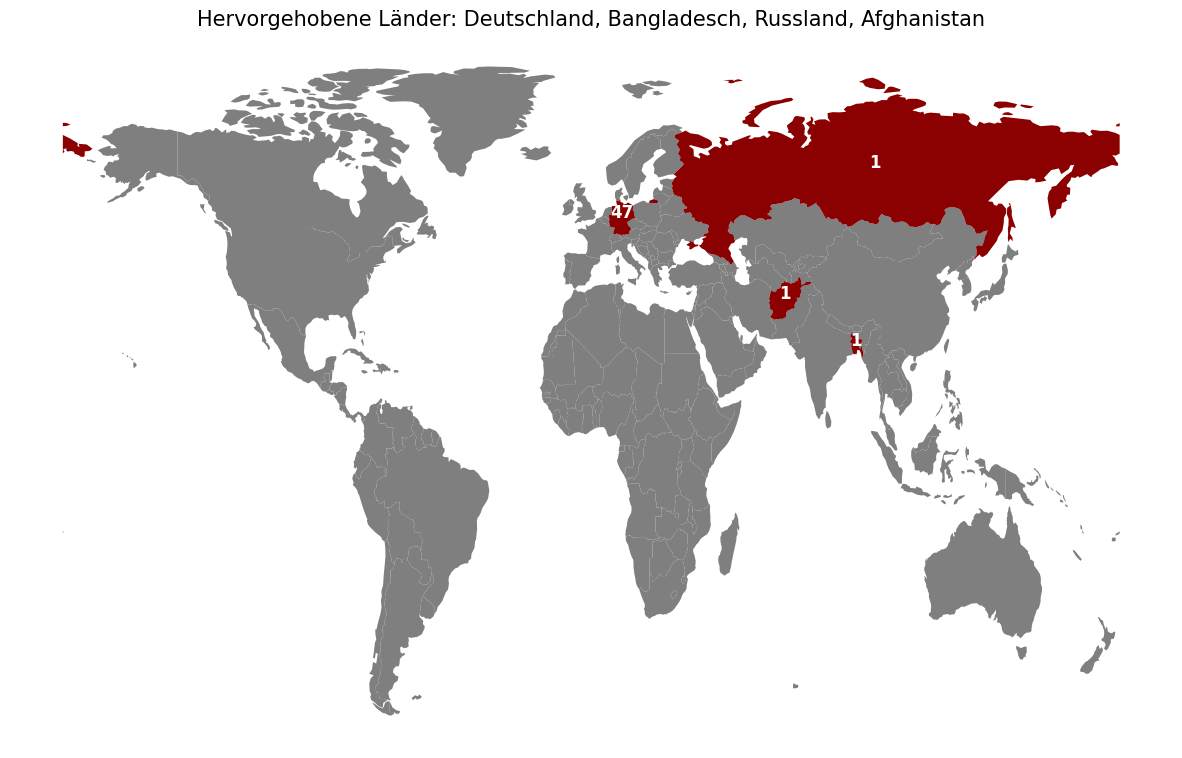

In [181]:
# Pfad zur heruntergeladenen und entpackten .shp Datei
shapefile_path = r"C:\Sync\03_projects\data_science\projects\weddingsurvey\geopandas_maps\ne_110m_admin_0_countries.shp"

# Weltkarte laden
world = gpd.read_file(shapefile_path)

# Entferne die Antarktis aus dem GeoDataFrame
world = world[world['NAME'] != 'Antarctica']

# Liste der Länder, die eingefärbt werden sollen, und ihre Zähler
highlight_countries = {
    'Germany': 47,
    'Bangladesh': 1,
    'Russia': 1,
    'Afghanistan': 1
}

# Erstelle eine Spalte, die festlegt, ob ein Land hervorgehoben wird
world['highlight'] = world['NAME'].apply(lambda x: 'Highlighted' if x in highlight_countries else 'Other')

# Plotten der Weltkarte
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Andere Länder in einem dunkleren Grau einfärben
world[world['highlight'] == 'Other'].plot(ax=ax, color='#7f7f7f')  # Dunkleres Grau

# Hervorgehobene Länder einfärben
highlighted = world[world['highlight'] == 'Highlighted']
highlighted.plot(ax=ax, color='darkred')

# Länderzähler in Weiß hinzufügen
for country, count in highlight_countries.items():
    country_geometry = highlighted[highlighted['NAME'] == country].geometry
    if not country_geometry.empty:
        x, y = country_geometry.centroid.x.values[0], country_geometry.centroid.y.values[0]
        ax.annotate(text=str(count), xy=(x, y), color='white', fontsize=12, ha='center', weight='bold')

# Titel und Achsen entfernen für eine saubere Darstellung
ax.set_title('Hervorgehobene Länder: Deutschland, Bangladesch, Russland, Afghanistan', fontsize=15)
ax.set_axis_off()

plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5700\47677015.py:35: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5700\47677015.py:35: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5700\47677015.py:35: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5700\47677015.py:35: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this o

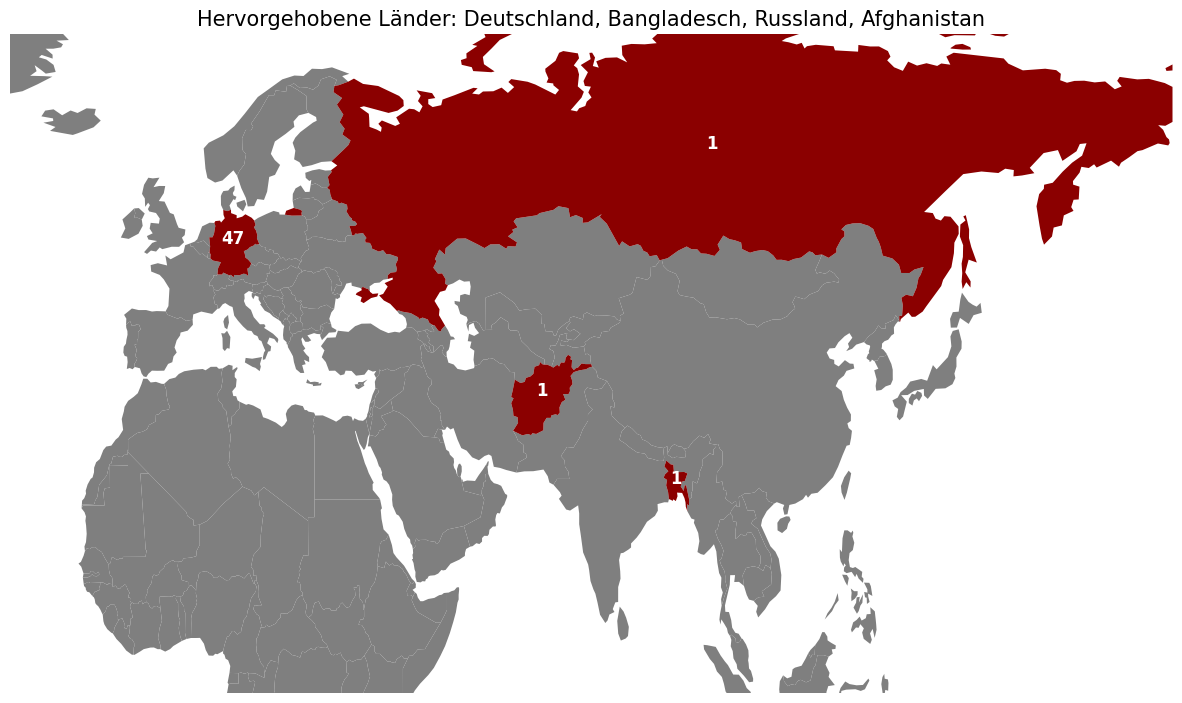

In [182]:
# Pfad zur heruntergeladenen und entpackten .shp Datei
shapefile_path = r"C:\Sync\03_projects\data_science\projects\weddingsurvey\geopandas_maps\ne_110m_admin_0_countries.shp"

# Weltkarte laden
world = gpd.read_file(shapefile_path)

# Entferne die Antarktis aus dem GeoDataFrame
world = world[world['NAME'] != 'Antarctica']

# Liste der Länder, die eingefärbt werden sollen, und ihre Zähler
highlight_countries = {
    'Germany': 47,
    'Bangladesh': 1,
    'Russia': 1,
    'Afghanistan': 1
}

# Erstelle eine Spalte, die festlegt, ob ein Land hervorgehoben wird
world['highlight'] = world['NAME'].apply(lambda x: 'Highlighted' if x in highlight_countries else 'Other')

# Plotten der Weltkarte
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Andere Länder in einem dunkleren Grau einfärben
world[world['highlight'] == 'Other'].plot(ax=ax, color='#7f7f7f')  # Dunkleres Grau

# Hervorgehobene Länder einfärben
highlighted = world[world['highlight'] == 'Highlighted']
highlighted.plot(ax=ax, color='darkred')

# Länderzähler in Weiß hinzufügen
for country, count in highlight_countries.items():
    country_geometry = highlighted[highlighted['NAME'] == country].geometry
    if not country_geometry.empty:
        x, y = country_geometry.centroid.x.values[0], country_geometry.centroid.y.values[0]
        ax.annotate(text=str(count), xy=(x, y), color='white', fontsize=12, ha='center', weight='bold')

# Titel und Achsen entfernen für eine saubere Darstellung
ax.set_title('Hervorgehobene Länder: Deutschland, Bangladesch, Russland, Afghanistan', fontsize=15)
ax.set_axis_off()

# Setzen der Grenzen für den Fokus auf Europa und Umgebung
ax.set_xlim([-30, 180])  # Begrenzung für die x-Achse (links von Europa bis Asien)
ax.set_ylim([0, 75])    # Begrenzung für die y-Achse (oberhalb Afghanistans)

plt.show()

## Wie lautet die Postleitzahl (PLZ) deines Wohnortes?

In [183]:
# Überprüfe die Häufigkeit der Postleitzahleneinträge
plz_counts = df['Wie lautet die Postleitzahl (PLZ) deines Wohnortes?'].value_counts()

# Zeige die Einträge und deren Häufigkeit an
plz_counts

Wie lautet die Postleitzahl (PLZ) deines Wohnortes?
67435    3
64319    3
64293    2
67434    2
50354    2
50825    2
63762    2
22767    2
80805    2
67059    2
60318    2
86159    2
20099    1
55116    1
89077    1
27804    1
50679    1
65183    1
56203    1
67470    1
78467    1
38106    1
69120    1
81543    1
80935    1
69181    1
63071    1
80337    1
13088    1
71083    1
81549    1
86161    1
81677    1
86157    1
64625    1
18246    1
Name: count, dtype: int64

In [184]:
# Speichere den ursprünglichen Umfragedatensatz in einem separaten DataFrame
survey_df = df.copy()

# Lade die Postleitzahldaten
plz_df = get_plz_dataframe()

# Konvertiere die Postleitzahlen im Umfragedatensatz in Strings und normiere sie auf 5 Ziffern
survey_df['PLZ_norm'] = survey_df['Wie lautet die Postleitzahl (PLZ) deines Wohnortes?'].astype(str).str.zfill(5)

# Normiere die Postleitzahlen im PLZ-Datensatz ebenfalls auf 5 Ziffern
plz_df.index = plz_df.index.str.strip().str.zfill(5)

# Filtere erneut den DataFrame auf die normierten PLZ
plz_list = survey_df['PLZ_norm'].unique()
df_filtered = plz_df[plz_df.index.isin(plz_list)]

Erfolgreich übereinstimmende Postleitzahlen gefunden.


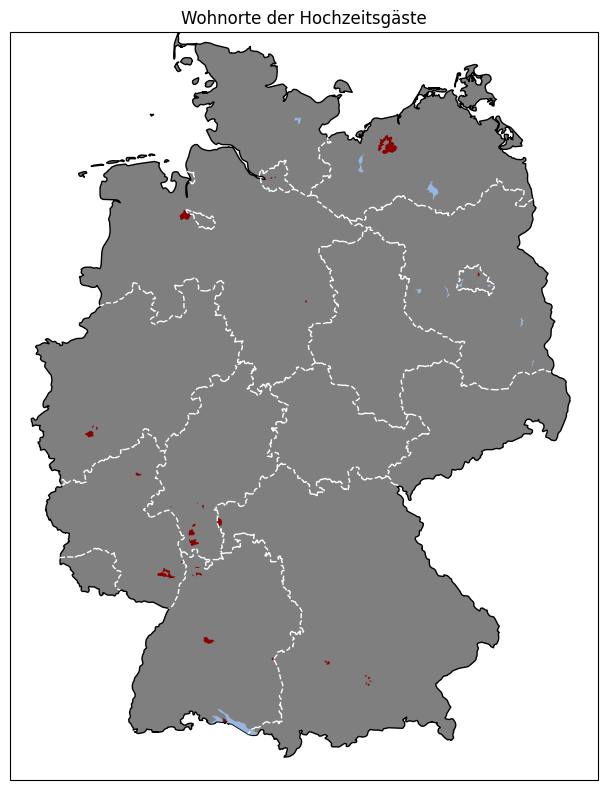

In [185]:
# Überprüfung, ob `df_filtered` jetzt Daten enthält
if df_filtered.empty:
    print("Warnung: Auch nach der Normierung stimmen keine Postleitzahlen überein.")
else:
    print("Erfolgreich übereinstimmende Postleitzahlen gefunden.")

# Wenn Übereinstimmungen gefunden werden, kannst du den Rest des Codes verwenden, um die Karte zu plotten
if not df_filtered.empty:

    # Filtere die Geometrien entsprechend den übereinstimmenden Postleitzahlen
    recs = load_plz_records()
    filtered_recs = [rec for rec in recs if rec.attributes['plz'] in df_filtered.index]

    # Plotten der Karte
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1, projection=crs.Mercator())

    # Engerer Zuschnitt um Deutschland
    ax.set_extent([5.5, 15.5, 47, 55], crs.PlateCarree())

    # Laden der Ländergrenzen
    shpfilename = shpreader.natural_earth(resolution='10m',
                                          category='cultural',
                                          name='admin_0_countries')

    reader = shpreader.Reader(shpfilename)
    countries = reader.records()

    # Färbe nur Deutschland
    germany_shape = None
    for country in countries:
        if country.attributes['NAME'] == 'Germany':  # Nur Deutschland färben
            germany_shape = country.geometry
            ax.add_geometries([country.geometry], crs.PlateCarree(),
                              edgecolor='k', facecolor='#7f7f7f', zorder=1)  # Füllung für Deutschland
        else:
            ax.add_geometries([country.geometry], crs.PlateCarree(),
                              edgecolor='none', facecolor='none', zorder=1)  # Keine Füllung für Nachbarländer

    # Shapefile für administrative Grenzen (Bundesländer) von Deutschland laden
    shpfilename = shpreader.natural_earth(resolution='10m',
                                          category='cultural',
                                          name='admin_1_states_provinces_lines')

    reader = shpreader.Reader(shpfilename)
    states = reader.records()

    # Nur Grenzen innerhalb von Deutschland plotten
    for state in states:
        if state.attributes['ADM0_NAME'] == 'Germany':  # Verwende 'ADM0_NAME' um Deutschland zu filtern
            ax.add_geometries([state.geometry], crs.PlateCarree(),
                              edgecolor='white', facecolor='none',
                              linestyle='--', linewidth=1, zorder=3)

    # Seen innerhalb Deutschlands hinzufügen
    shpfilename = shpreader.natural_earth(resolution='10m',
                                          category='physical',
                                          name='lakes')

    reader = shpreader.Reader(shpfilename)
    lakes = reader.records()

    for lake in lakes:
        if germany_shape.intersects(lake.geometry):  # Nur Seen innerhalb Deutschlands
            # Schnitt der Geometrie des Sees mit der Geometrie Deutschlands
            intersection = germany_shape.intersection(lake.geometry)
            ax.add_geometries([intersection], crs.PlateCarree(),
                              edgecolor='none', facecolor=feature.COLORS['water'], zorder=2)

    # Funktion zur Anpassung von MultiPolygon-Objekten für die Plot-Daten
    def build_patch_collection_fixed(filtered_recs):
        patches = []
        repeat = np.zeros(len(filtered_recs), dtype=int)
        for i, rec in enumerate(filtered_recs):
            if rec.geometry.geom_type == 'Polygon':
                iterable_geo = [rec.geometry]
            elif rec.geometry.geom_type == 'MultiPolygon':
                iterable_geo = rec.geometry.geoms
            else:
                iterable_geo = [rec.geometry]

            for geom in iterable_geo:
                repeat[i] += 1

                if isinstance(geom.boundary, MultiLineString):
                    for line in geom.boundary.geoms:
                        xy = np.array(line.xy).T
                        patches.append(Polygon(xy, closed=True))
                else:
                    xy = np.array(geom.boundary.xy).T
                    patches.append(Polygon(xy, closed=True))

        collection = PatchCollection(patches, transform=crs.Mercator.GOOGLE, zorder=2)
        collection.set_facecolor('darkred')  # Setze die Füllfarbe für alle Polygone auf ein knalliges Rot
        collection.set_edgecolor('none')  # Entferne die Konturfarbe

        return collection, repeat

    # Anpassung des Builds der Patch Collection
    col, _ = build_patch_collection_fixed(filtered_recs)

    ax.add_collection(col)

    ax.set_title('Wohnorte der Hochzeitsgäste')

    fig.tight_layout()
    plt.show()


# 3. Nur eine Antwort möglich

## Mit welchem Geschlecht identifizierst du dich?

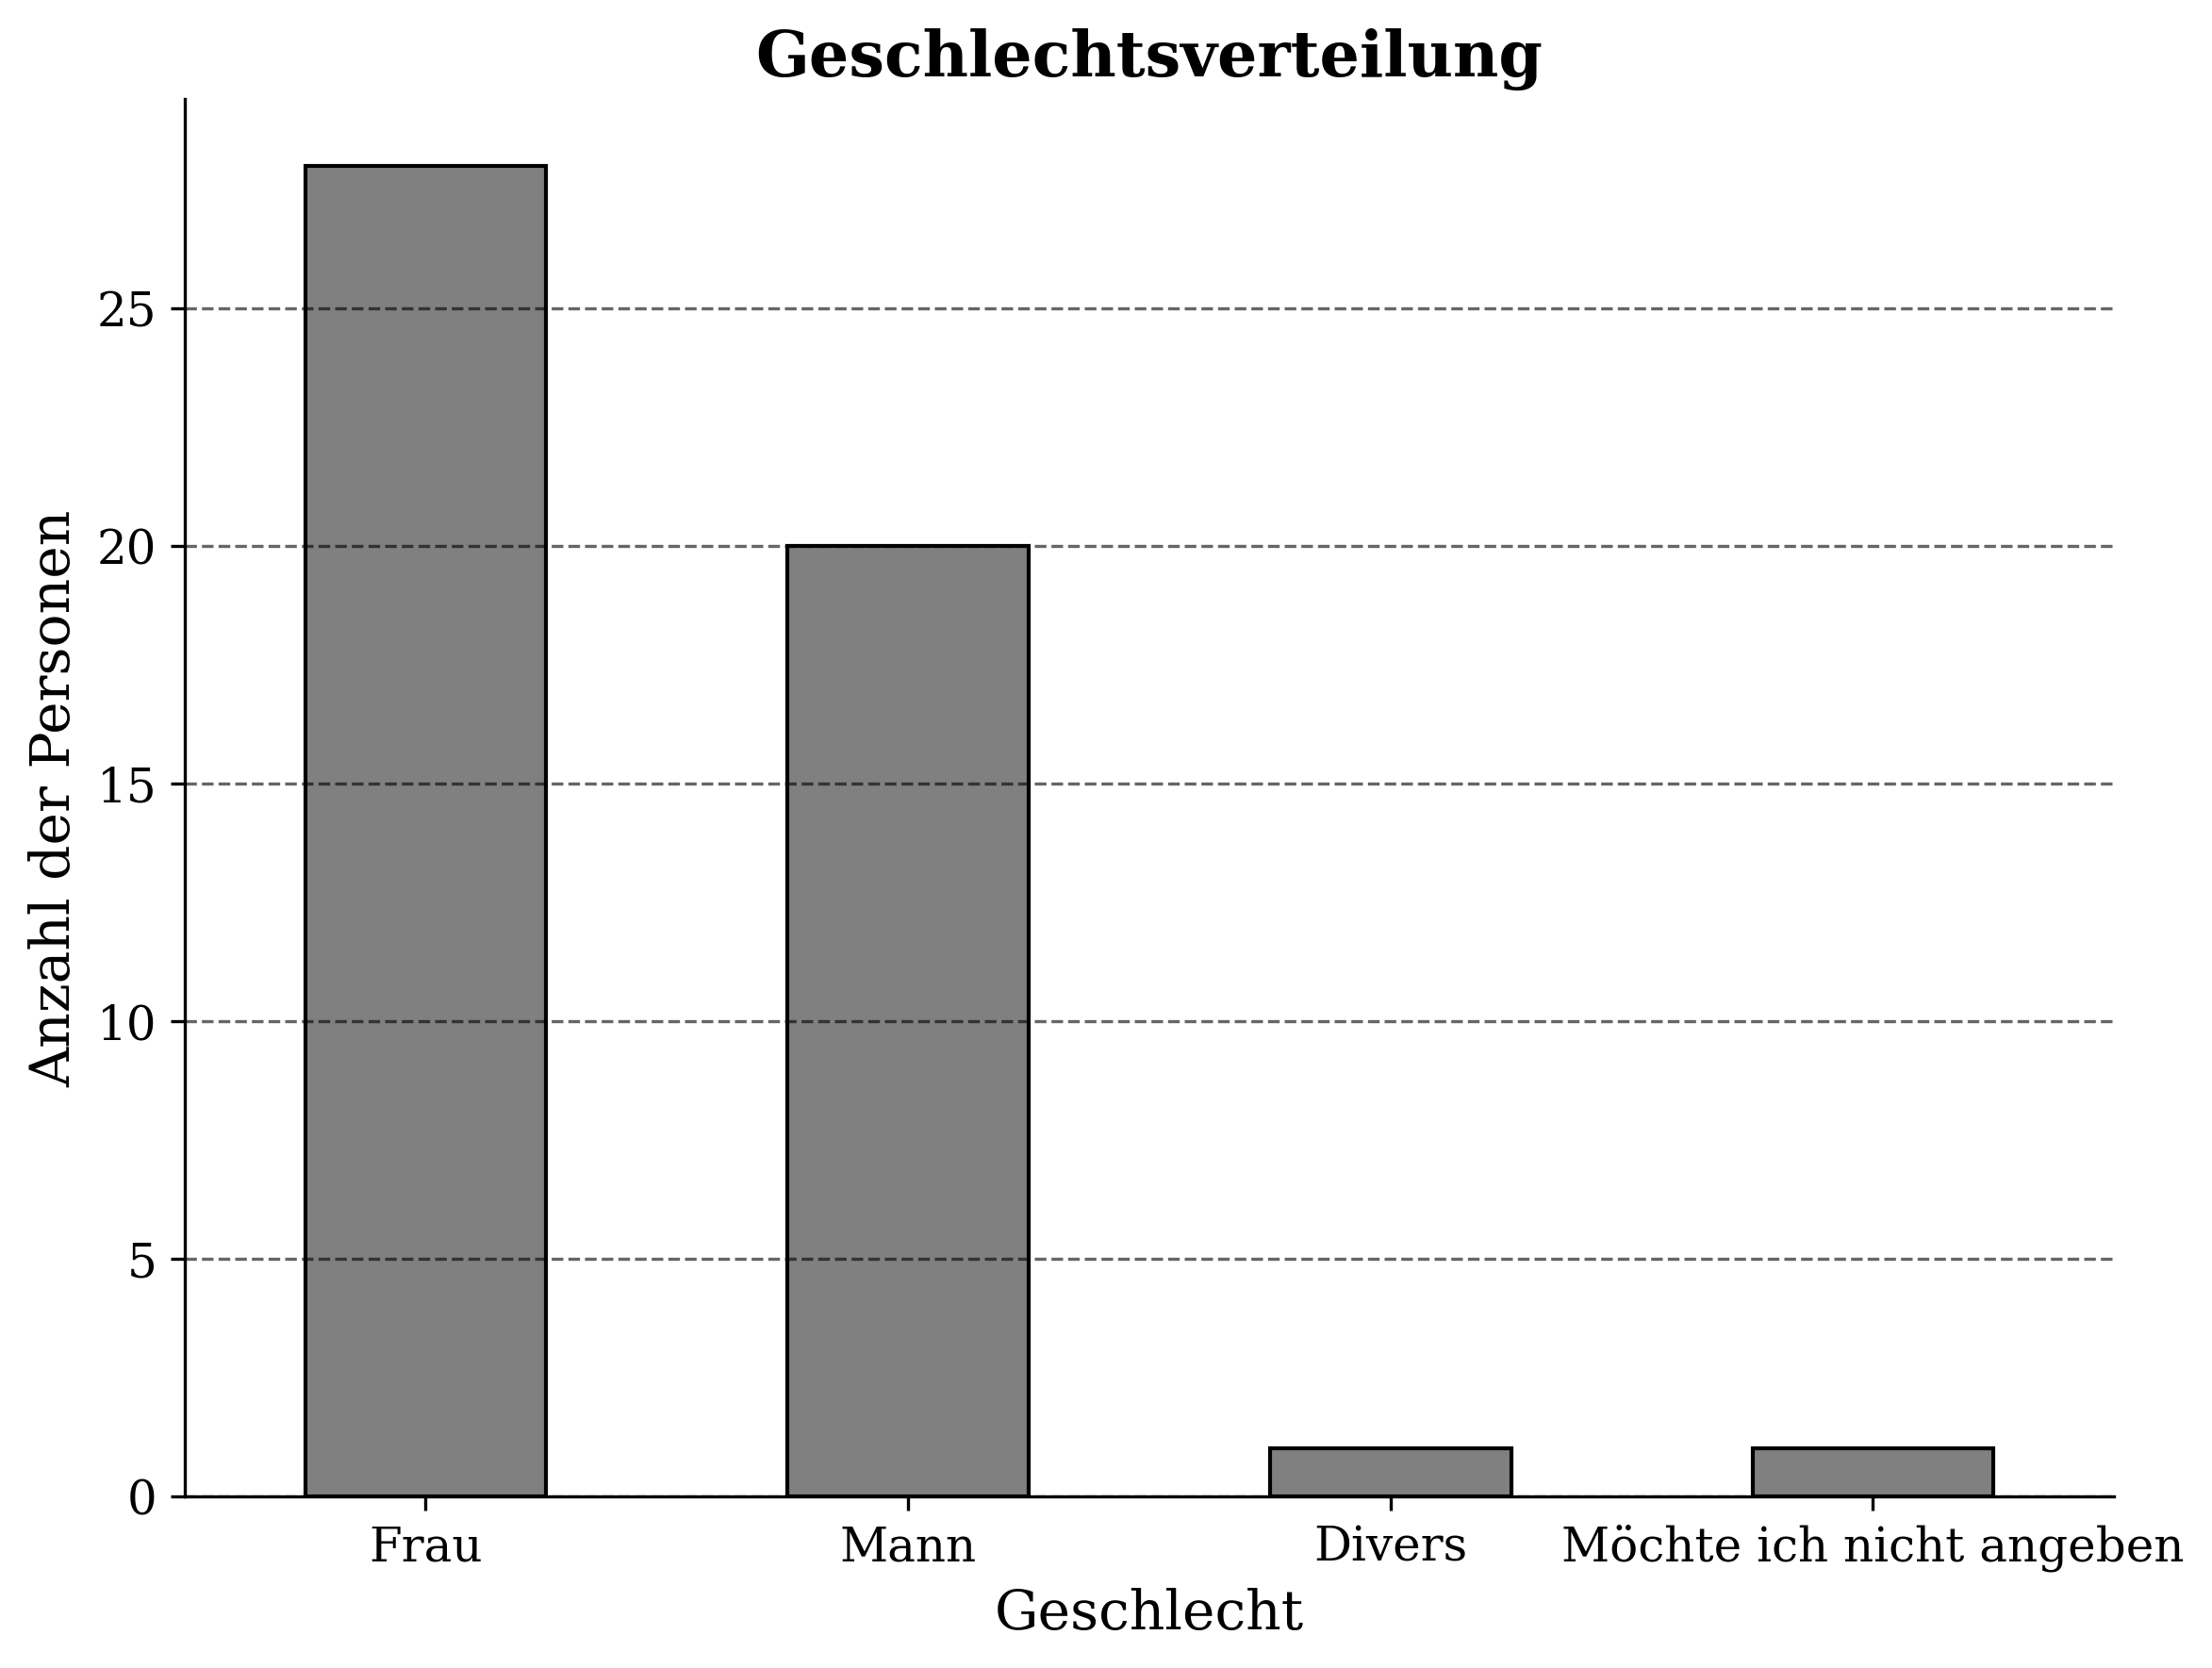

In [186]:
# Berechne die Häufigkeit der Antworten
gender_counts = df['Mit welchem Geschlecht identifizierst du dich?'].value_counts()

# Erstelle ein Balkendiagramm der Geschlechtsverteilung
plt.figure(figsize=(8, 6), dpi=300)
gender_counts.plot(kind='bar', color='gray', edgecolor='black')
plt.title('Geschlechtsverteilung', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Geschlecht', fontsize=14, family='serif')
plt.ylabel('Anzahl der Personen', fontsize=14, family='serif')
plt.xticks(rotation=0, fontsize=12, family='serif')
plt.yticks(fontsize=12, family='serif')
plt.grid(axis='y', linestyle='--', alpha=0.6, color='black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()  # Optimiert den Layout-Abstand
plt.show()

## Wie ist dein Familienstand?

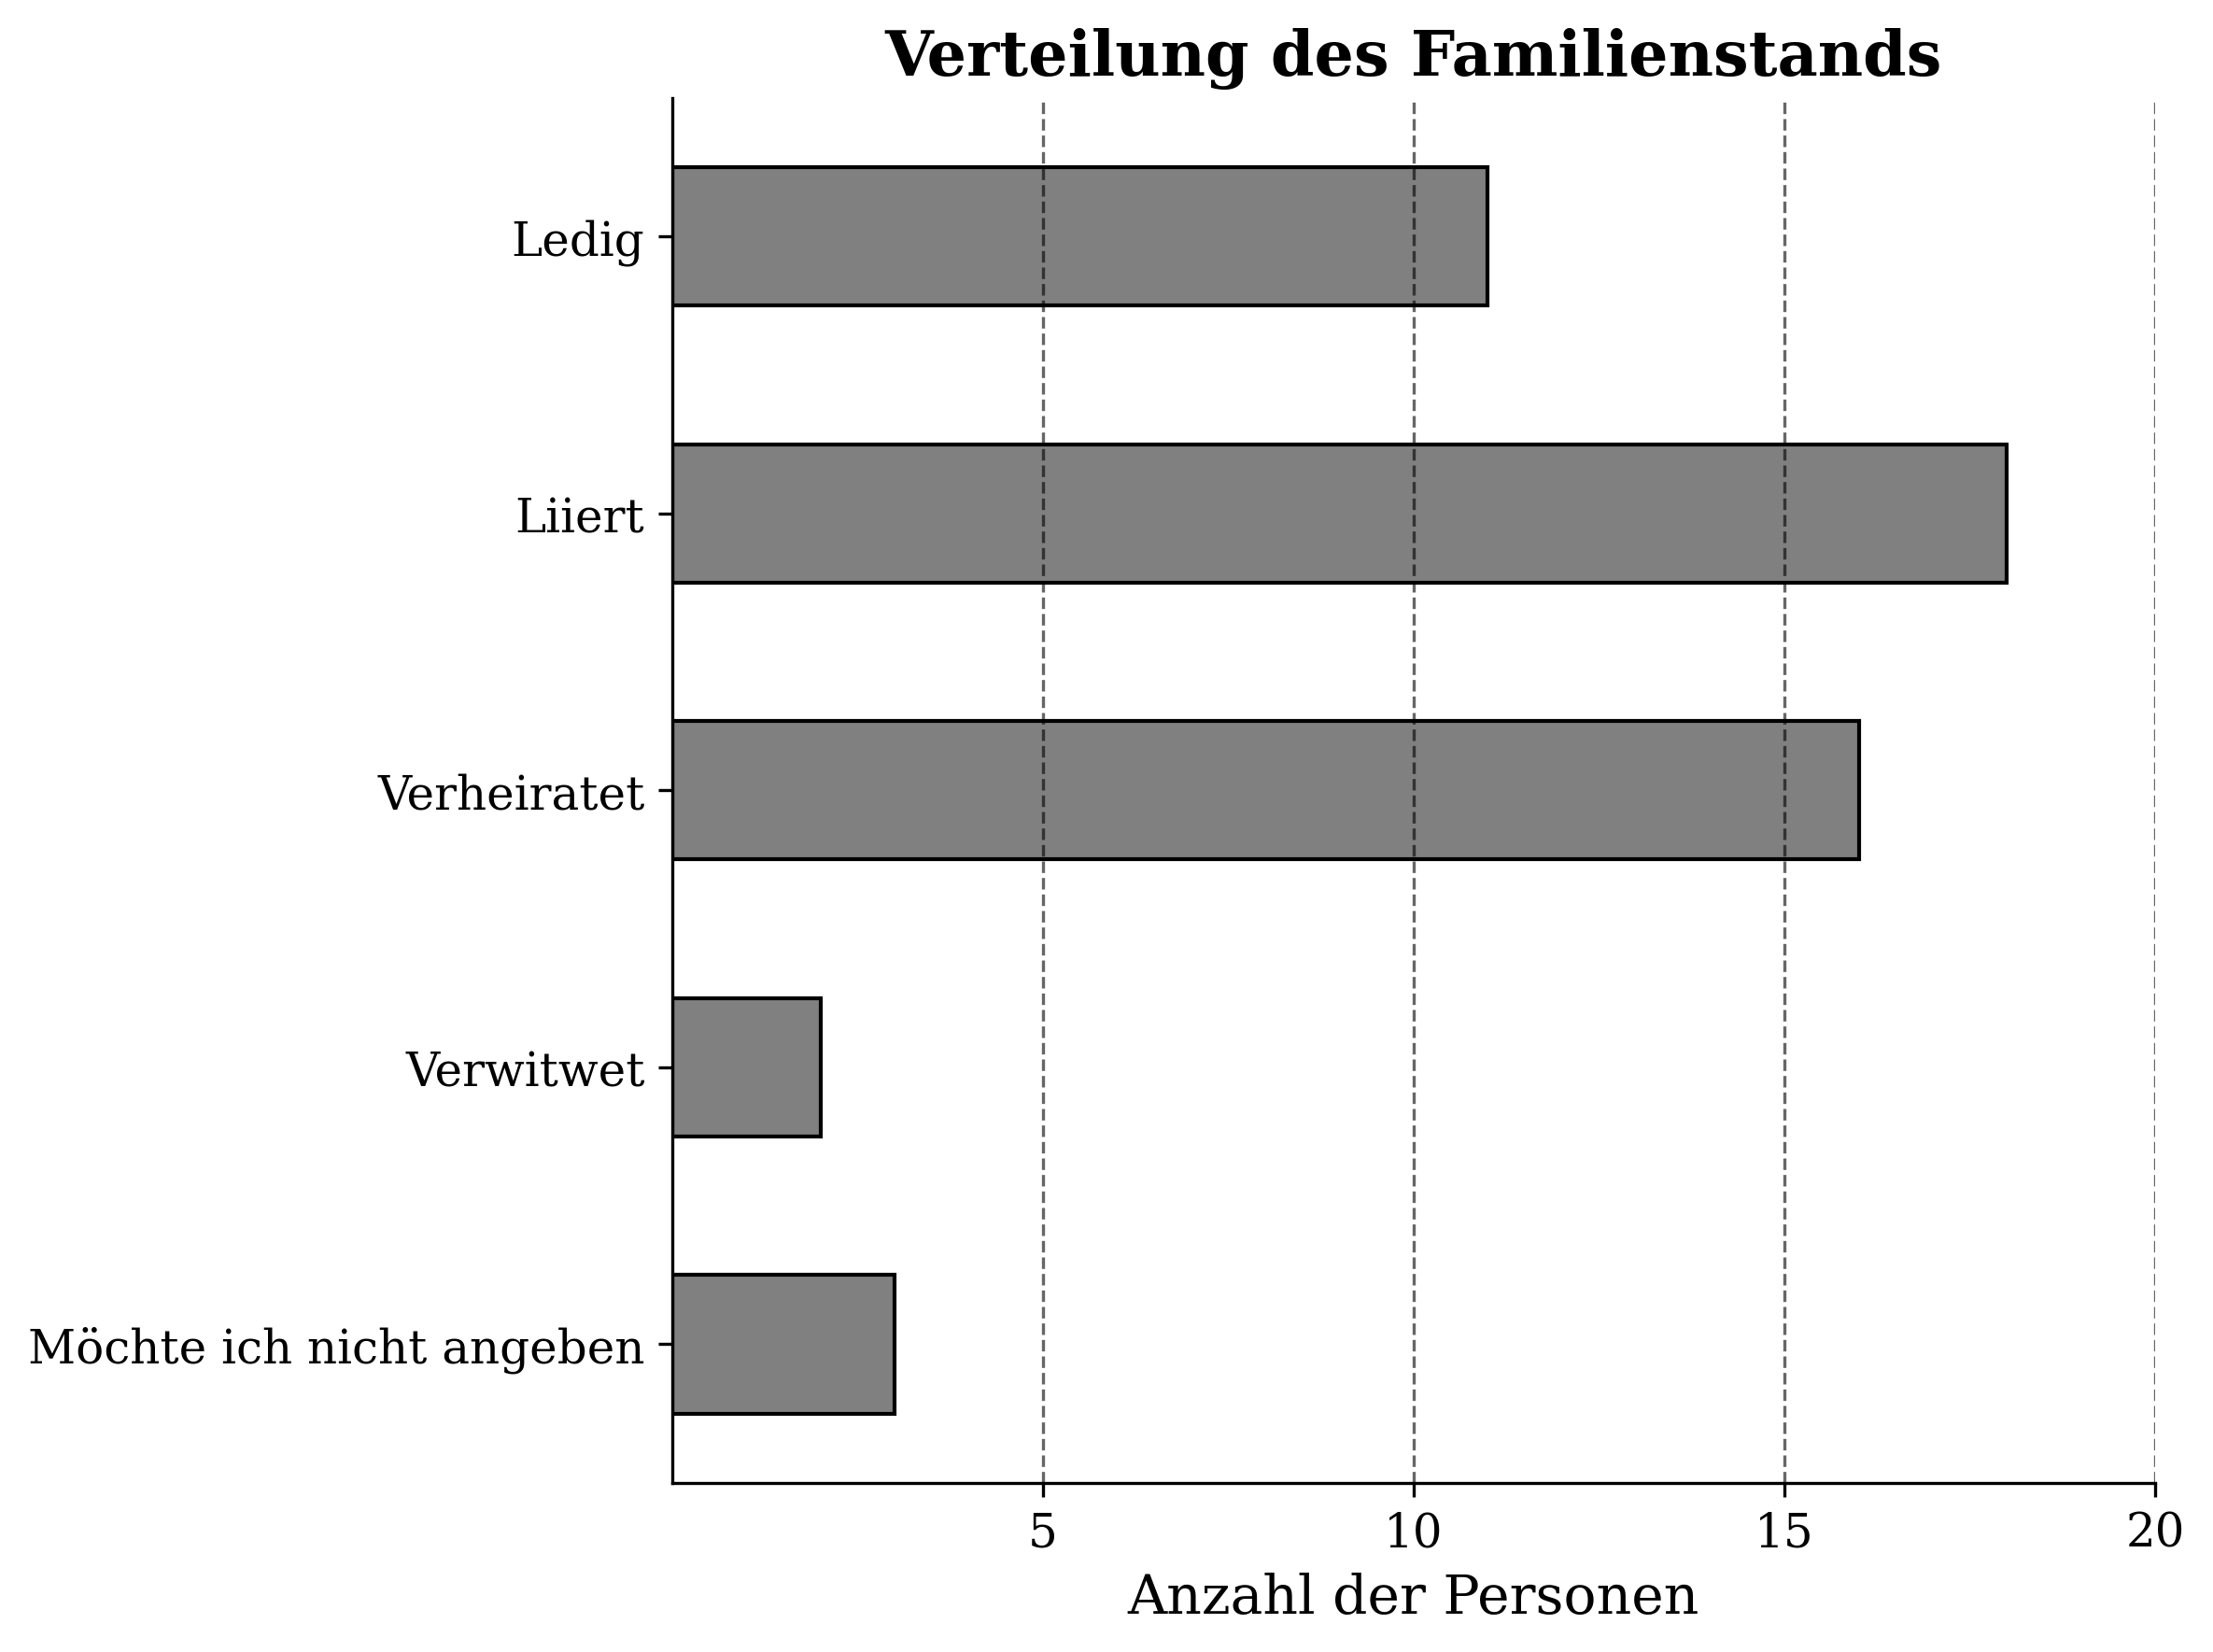

In [192]:
# Definiere die gewünschte Reihenfolge der Kategorien, umgekehrt
reihenfolge = ['Möchte ich nicht angeben', 'Verwitwet', 'Verheiratet', 'Liiert', 'Ledig']

# Berechne die Häufigkeit der Antworten und ordne sie nach der umgekehrten Reihenfolge
familienstand_counts = df['Wie ist dein Familienstand?'].value_counts().reindex(reihenfolge)

# Erstelle ein Balkendiagramm der Familienstandsverteilung mit invertierten Achsen und der spezifischen Reihenfolge
plt.figure(figsize=(8, 6), dpi=300)
familienstand_counts.plot(kind='barh', color='gray', edgecolor='black')  # 'barh' für horizontales Balkendiagramm
plt.title('Verteilung des Familienstands', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Anzahl der Personen', fontsize=14, family='serif')
plt.ylabel('')  # Entfernt den Y-Achsentitel
plt.xticks([5, 10, 15, 20], fontsize=12, family='serif')  # Setzt die X-Achsen-Ticks auf 5, 10, 15, 20
plt.yticks(fontsize=12, family='serif')
plt.grid(axis='x', linestyle='--', alpha=0.6, color='black')  # Gitterlinien entlang der X-Achse
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()  # Optimiert den Layout-Abstand
plt.show()


## Wie ist dein Familienstand?

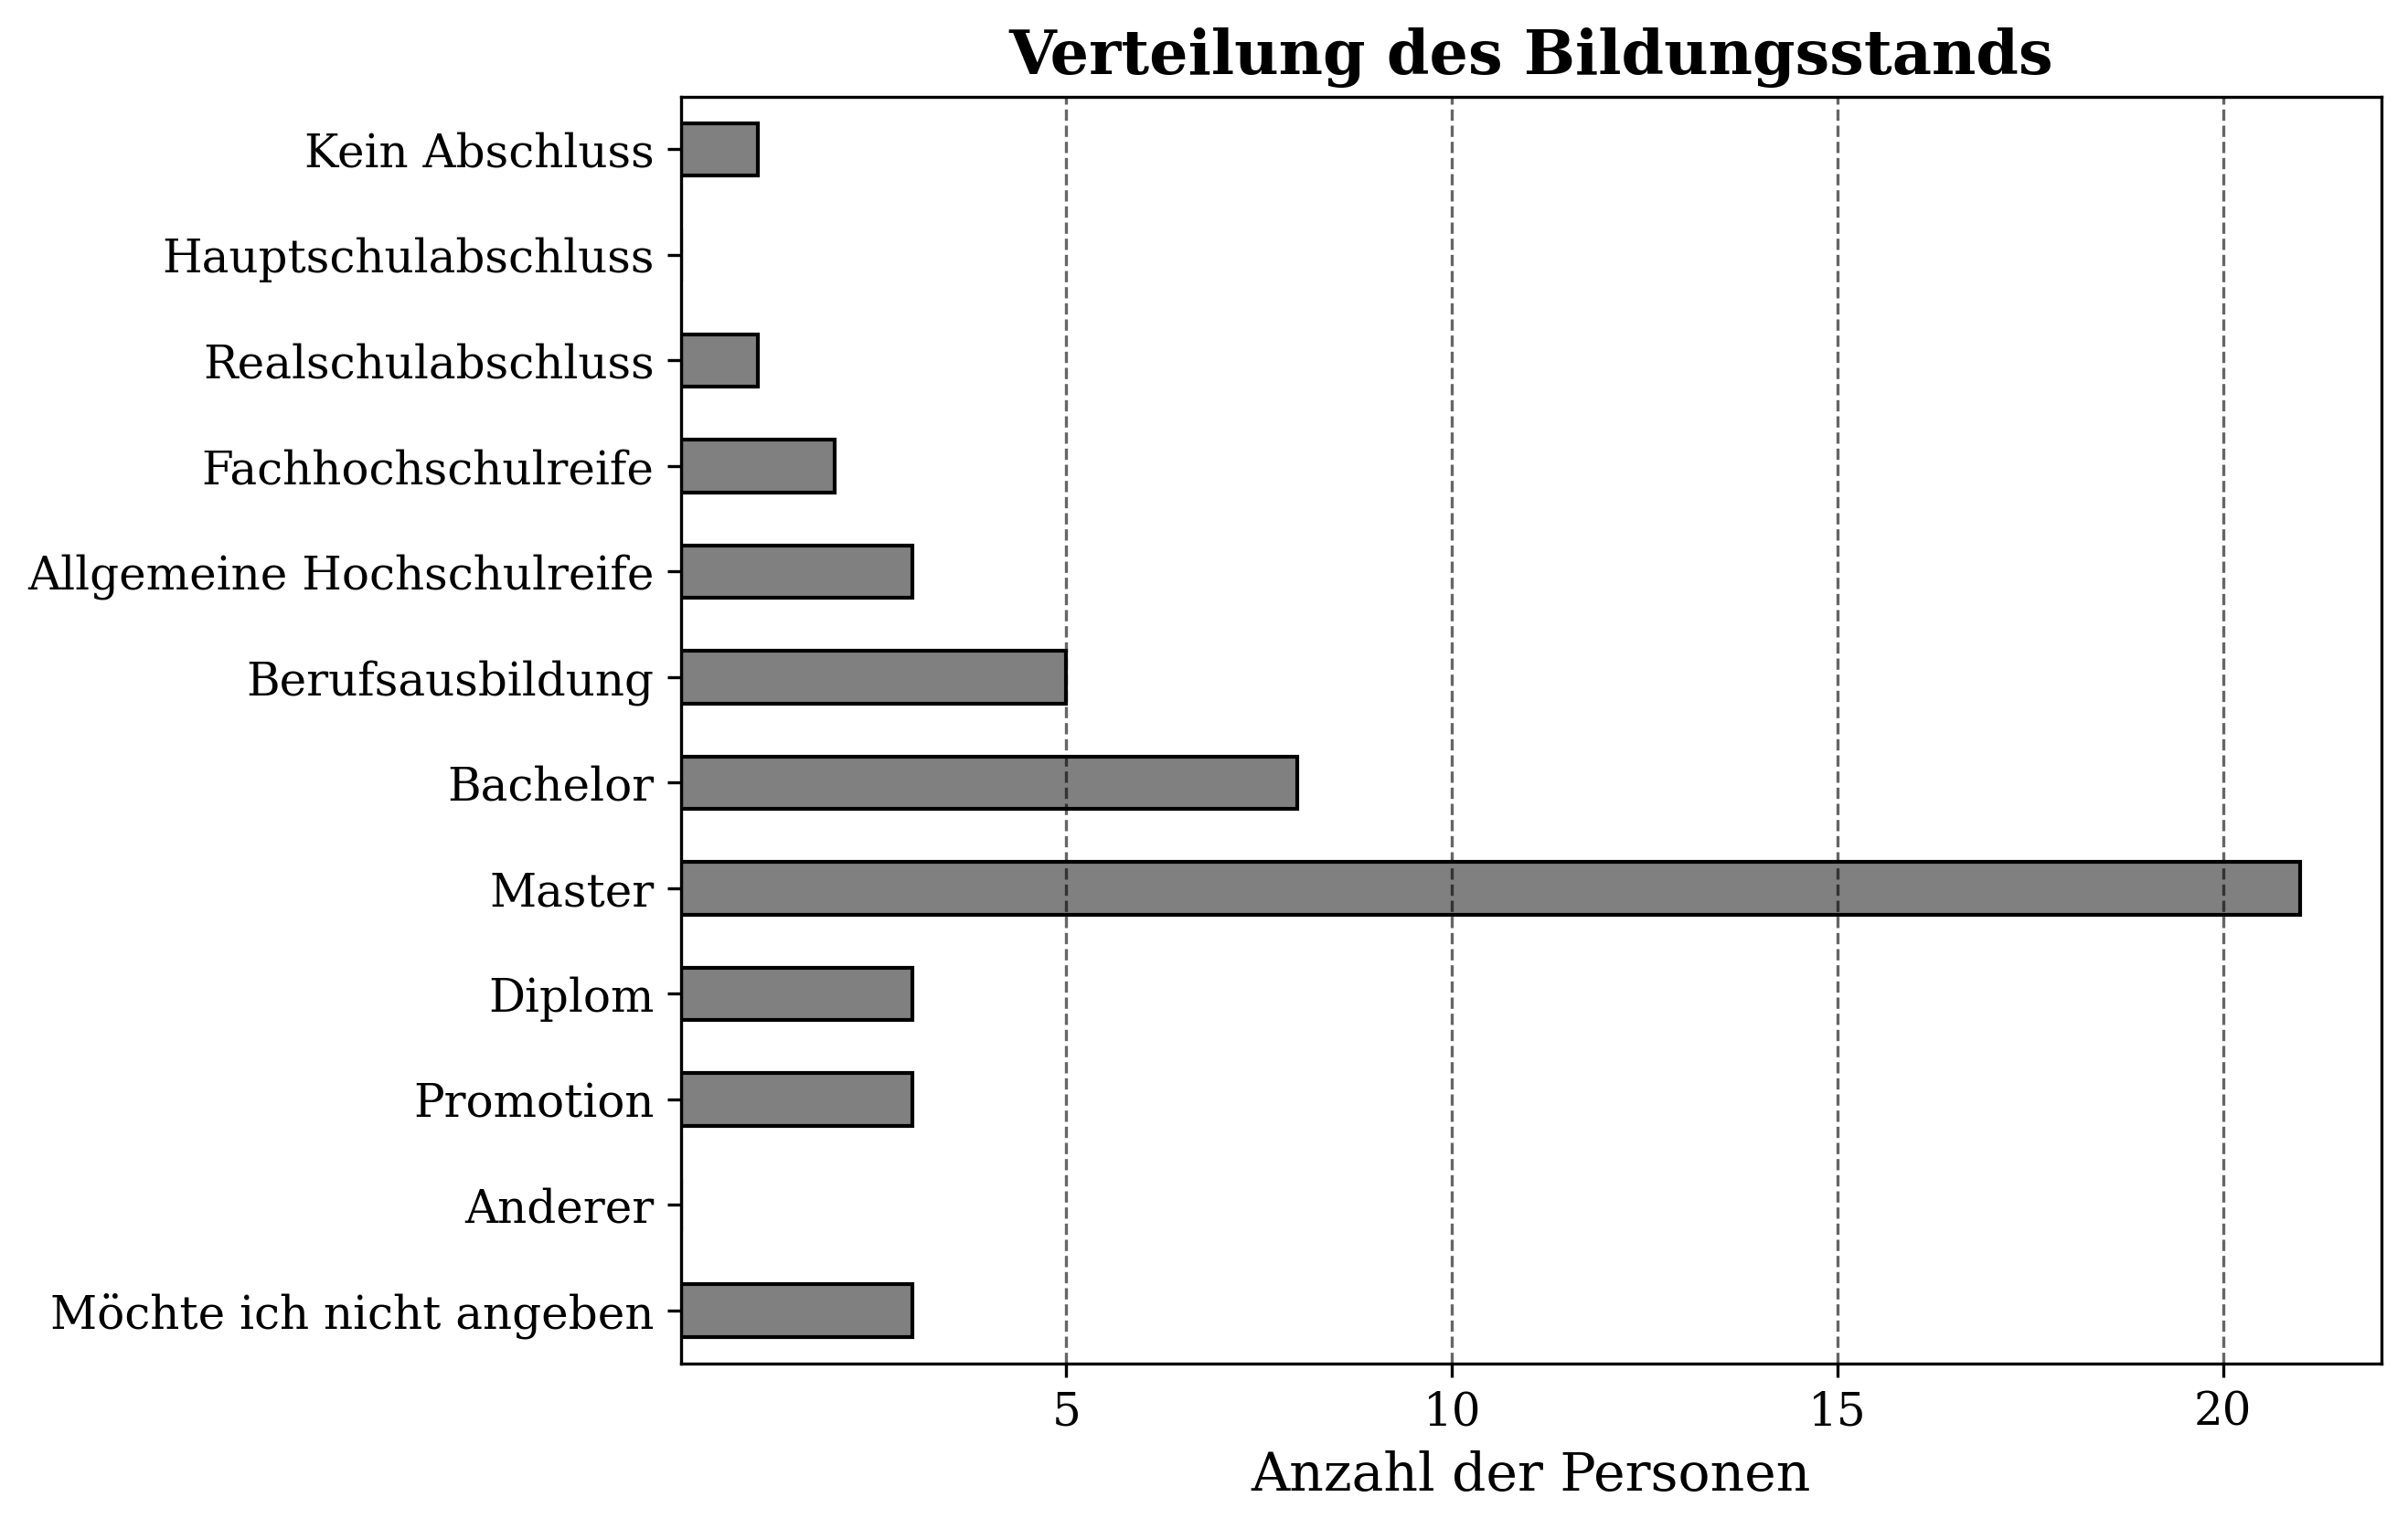

In [194]:
# Definiere die umgekehrte Reihenfolge der Kategorien für den Bildungsstand
reihenfolge_bildungsstand = [
    'Möchte ich nicht angeben',
    'Anderer',
    'Promotion',
    'Diplom',
    'Master',
    'Bachelor',
    'Berufsausbildung',
    'Allgemeine Hochschulreife',
    'Fachhochschulreife',
    'Realschulabschluss',
    'Hauptschulabschluss',
    'Kein Abschluss'
]

# Berechne die Häufigkeit der Antworten und ordne sie nach der umgekehrten Reihenfolge
bildungsstand_counts = df['Welchen höchsten Bildungsstand hast du erreicht?'].value_counts().reindex(reihenfolge_bildungsstand)

# Erstelle ein Balkendiagramm der Bildungsstandsverteilung mit invertierten Achsen und der spezifischen Reihenfolge
plt.figure(figsize=(8, 6), dpi=300)
bildungsstand_counts.plot(kind='barh', color='gray', edgecolor='black')  # 'barh' für horizontales Balkendiagramm
plt.title('Verteilung des Bildungsstands', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Anzahl der Personen', fontsize=14, family='serif')
plt.ylabel('')  # Entfernt den Y-Achsentitel
plt.xticks([5, 10, 15, 20], fontsize=12, family='serif')  # Setzt die X-Achsen-Ticks auf 5, 10, 15, 20
plt.yticks(fontsize=12, family='serif')
plt.grid(axis='x', linestyle='--', alpha=0.6, color='black')  # Gitterlinien entlang der X-Achse


## In welcher Branche arbeitest du?

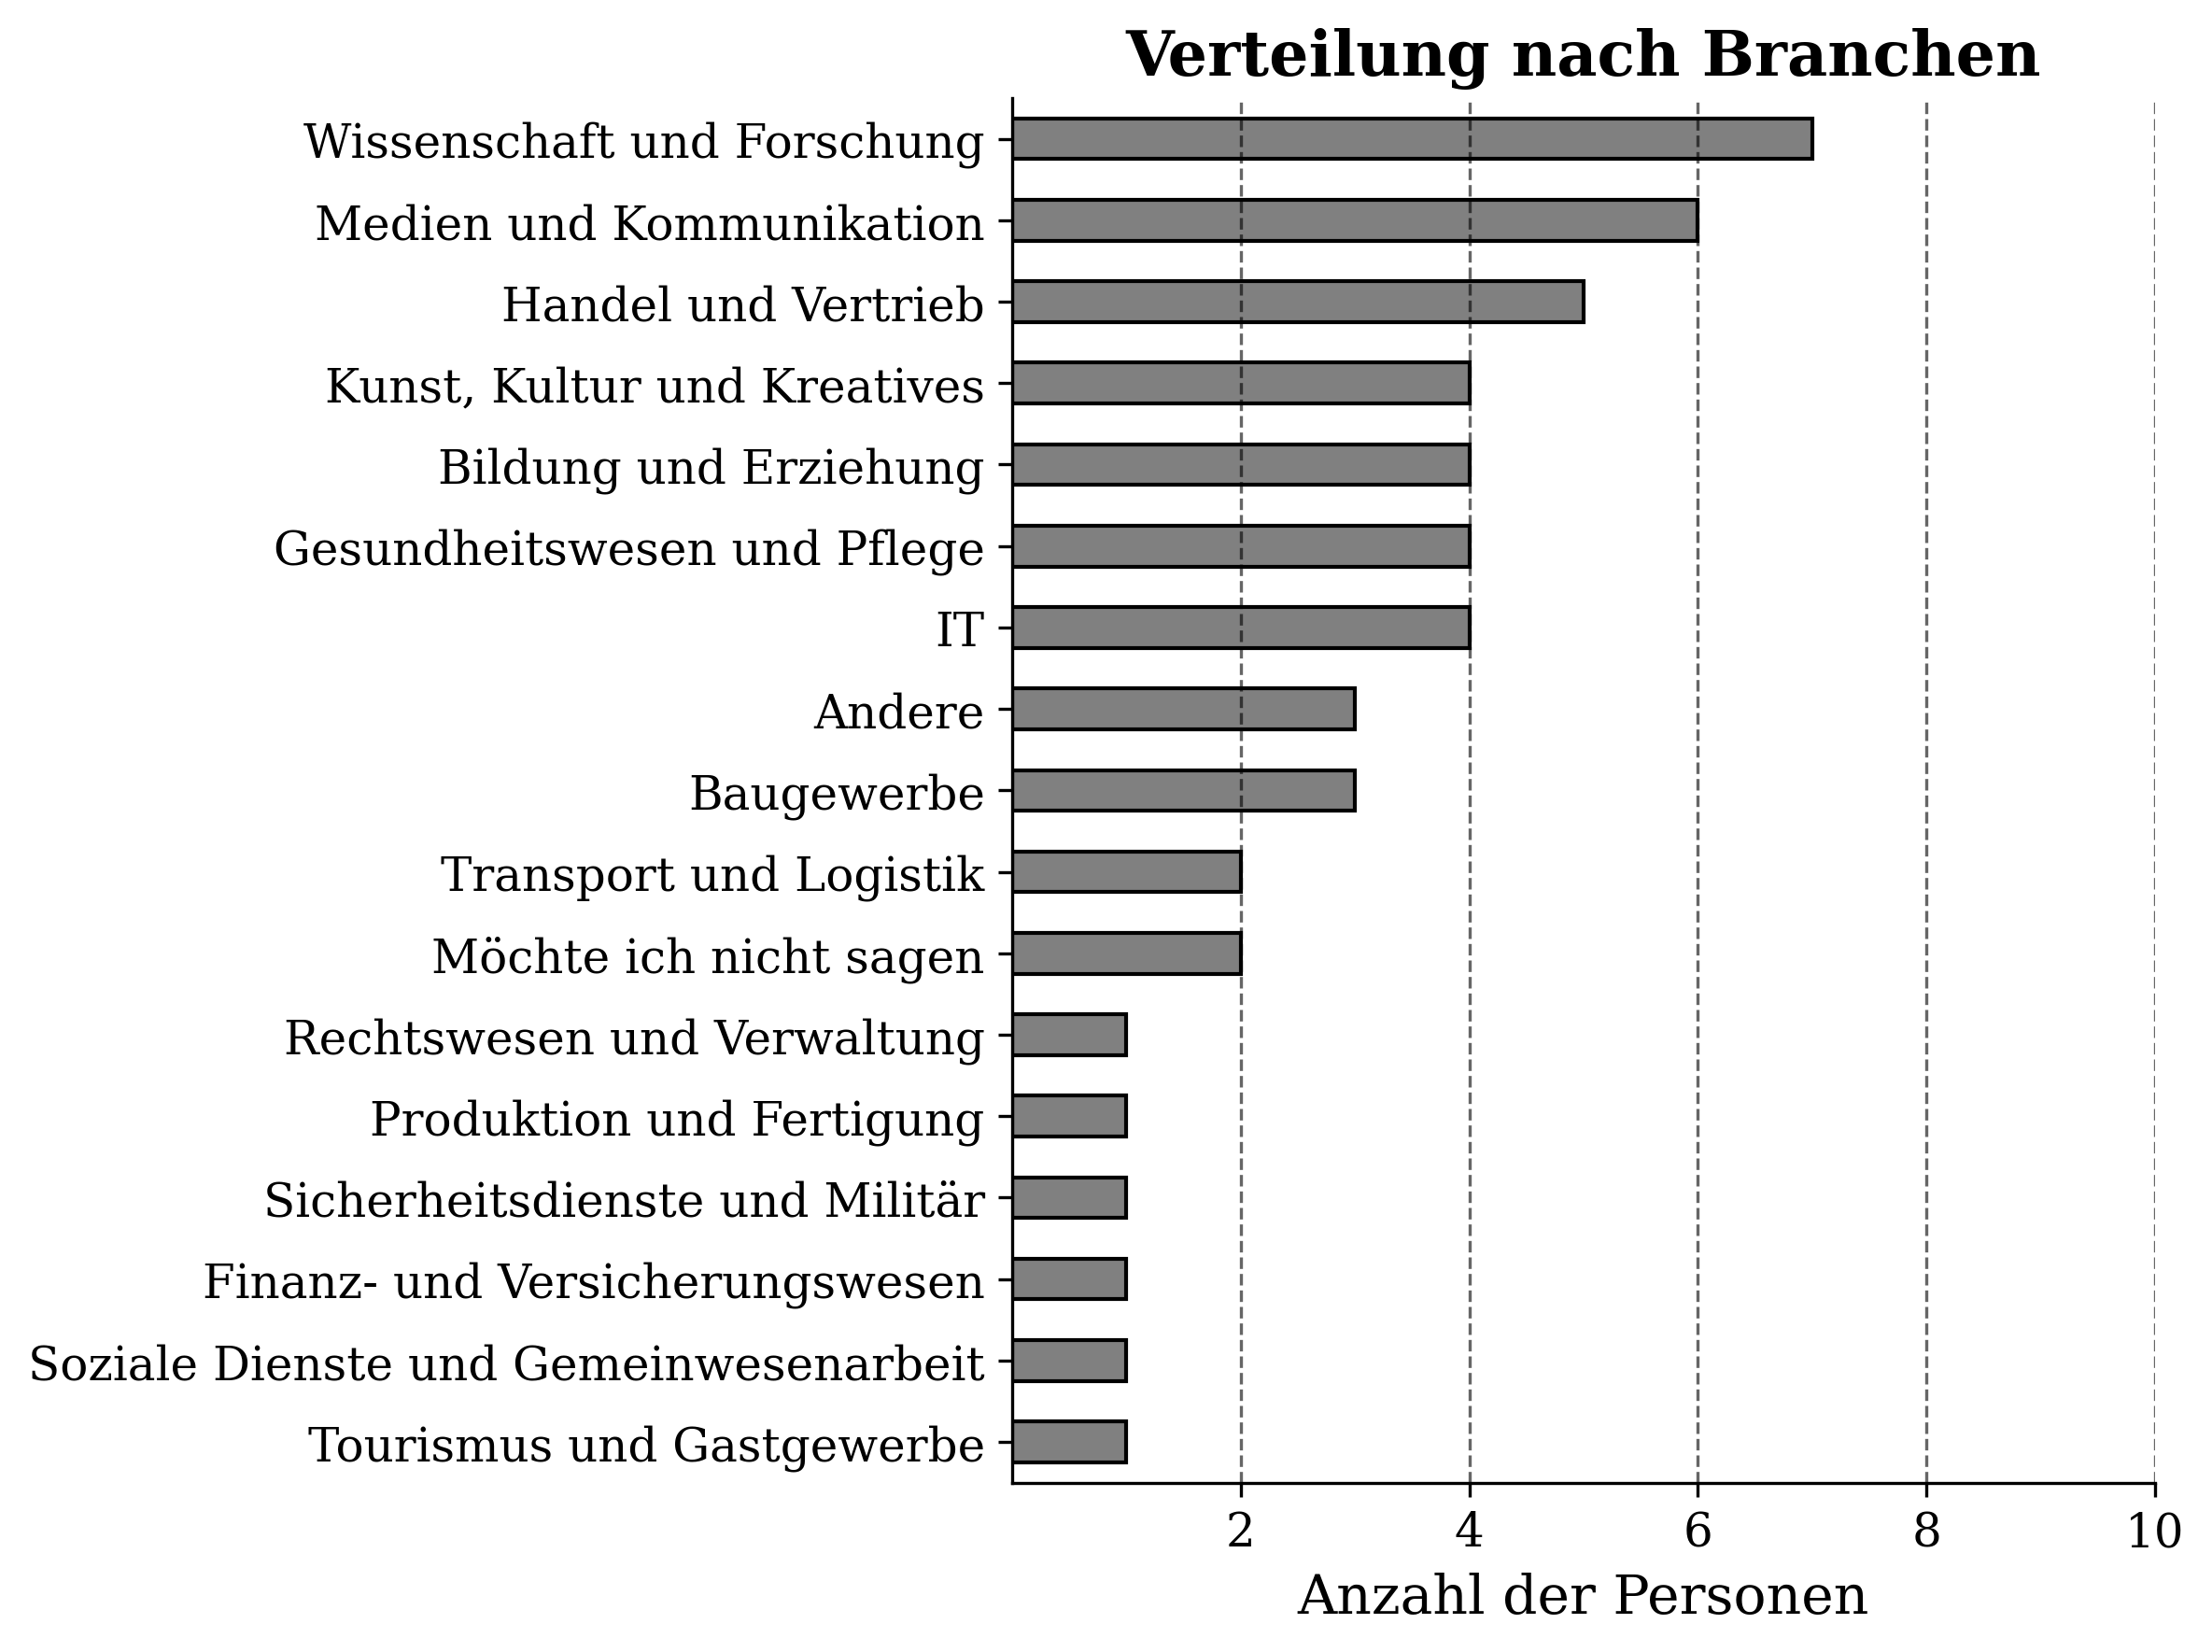

In [212]:
# Berechne die Häufigkeit der Antworten und sortiere sie in aufsteigender Reihenfolge
branche_counts = df['In welcher Branche arbeitest du?'].value_counts(ascending=True)

# Ersetze das Label "Informations- und Kommunikationstechnologie (IT)" durch "IT" im Plot
branche_counts.index = branche_counts.index.str.replace(
    'Informations- und Kommunikationstechnologie (IT)', 'IT')

# Erstelle ein Balkendiagramm der Branchenverteilung mit invertierten Achsen und aufsteigender Sortierung
plt.figure(figsize=(8, 6), dpi=300)
branche_counts.plot(kind='barh', color='gray', edgecolor='black')  # 'barh' für horizontales Balkendiagramm
plt.title('Verteilung nach Branchen', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Anzahl der Personen', fontsize=14, family='serif')
plt.ylabel('')  # Entfernt den Y-Achsentitel
plt.xticks([2, 4, 6, 8, 10], fontsize=12, family='serif')  # Setzt die X-Achsen-Ticks auf 2, 4, 6, 8, 10
plt.yticks(fontsize=12, family='serif')
plt.grid(axis='x', linestyle='--', alpha=0.6, color='black')  # Gitterlinien entlang der X-Achse
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()  # Optimiert den Layout-Abstand
plt.show()


## Was ist deine aktuelle Haupttätigkeit (trifft am ehesten zu)?

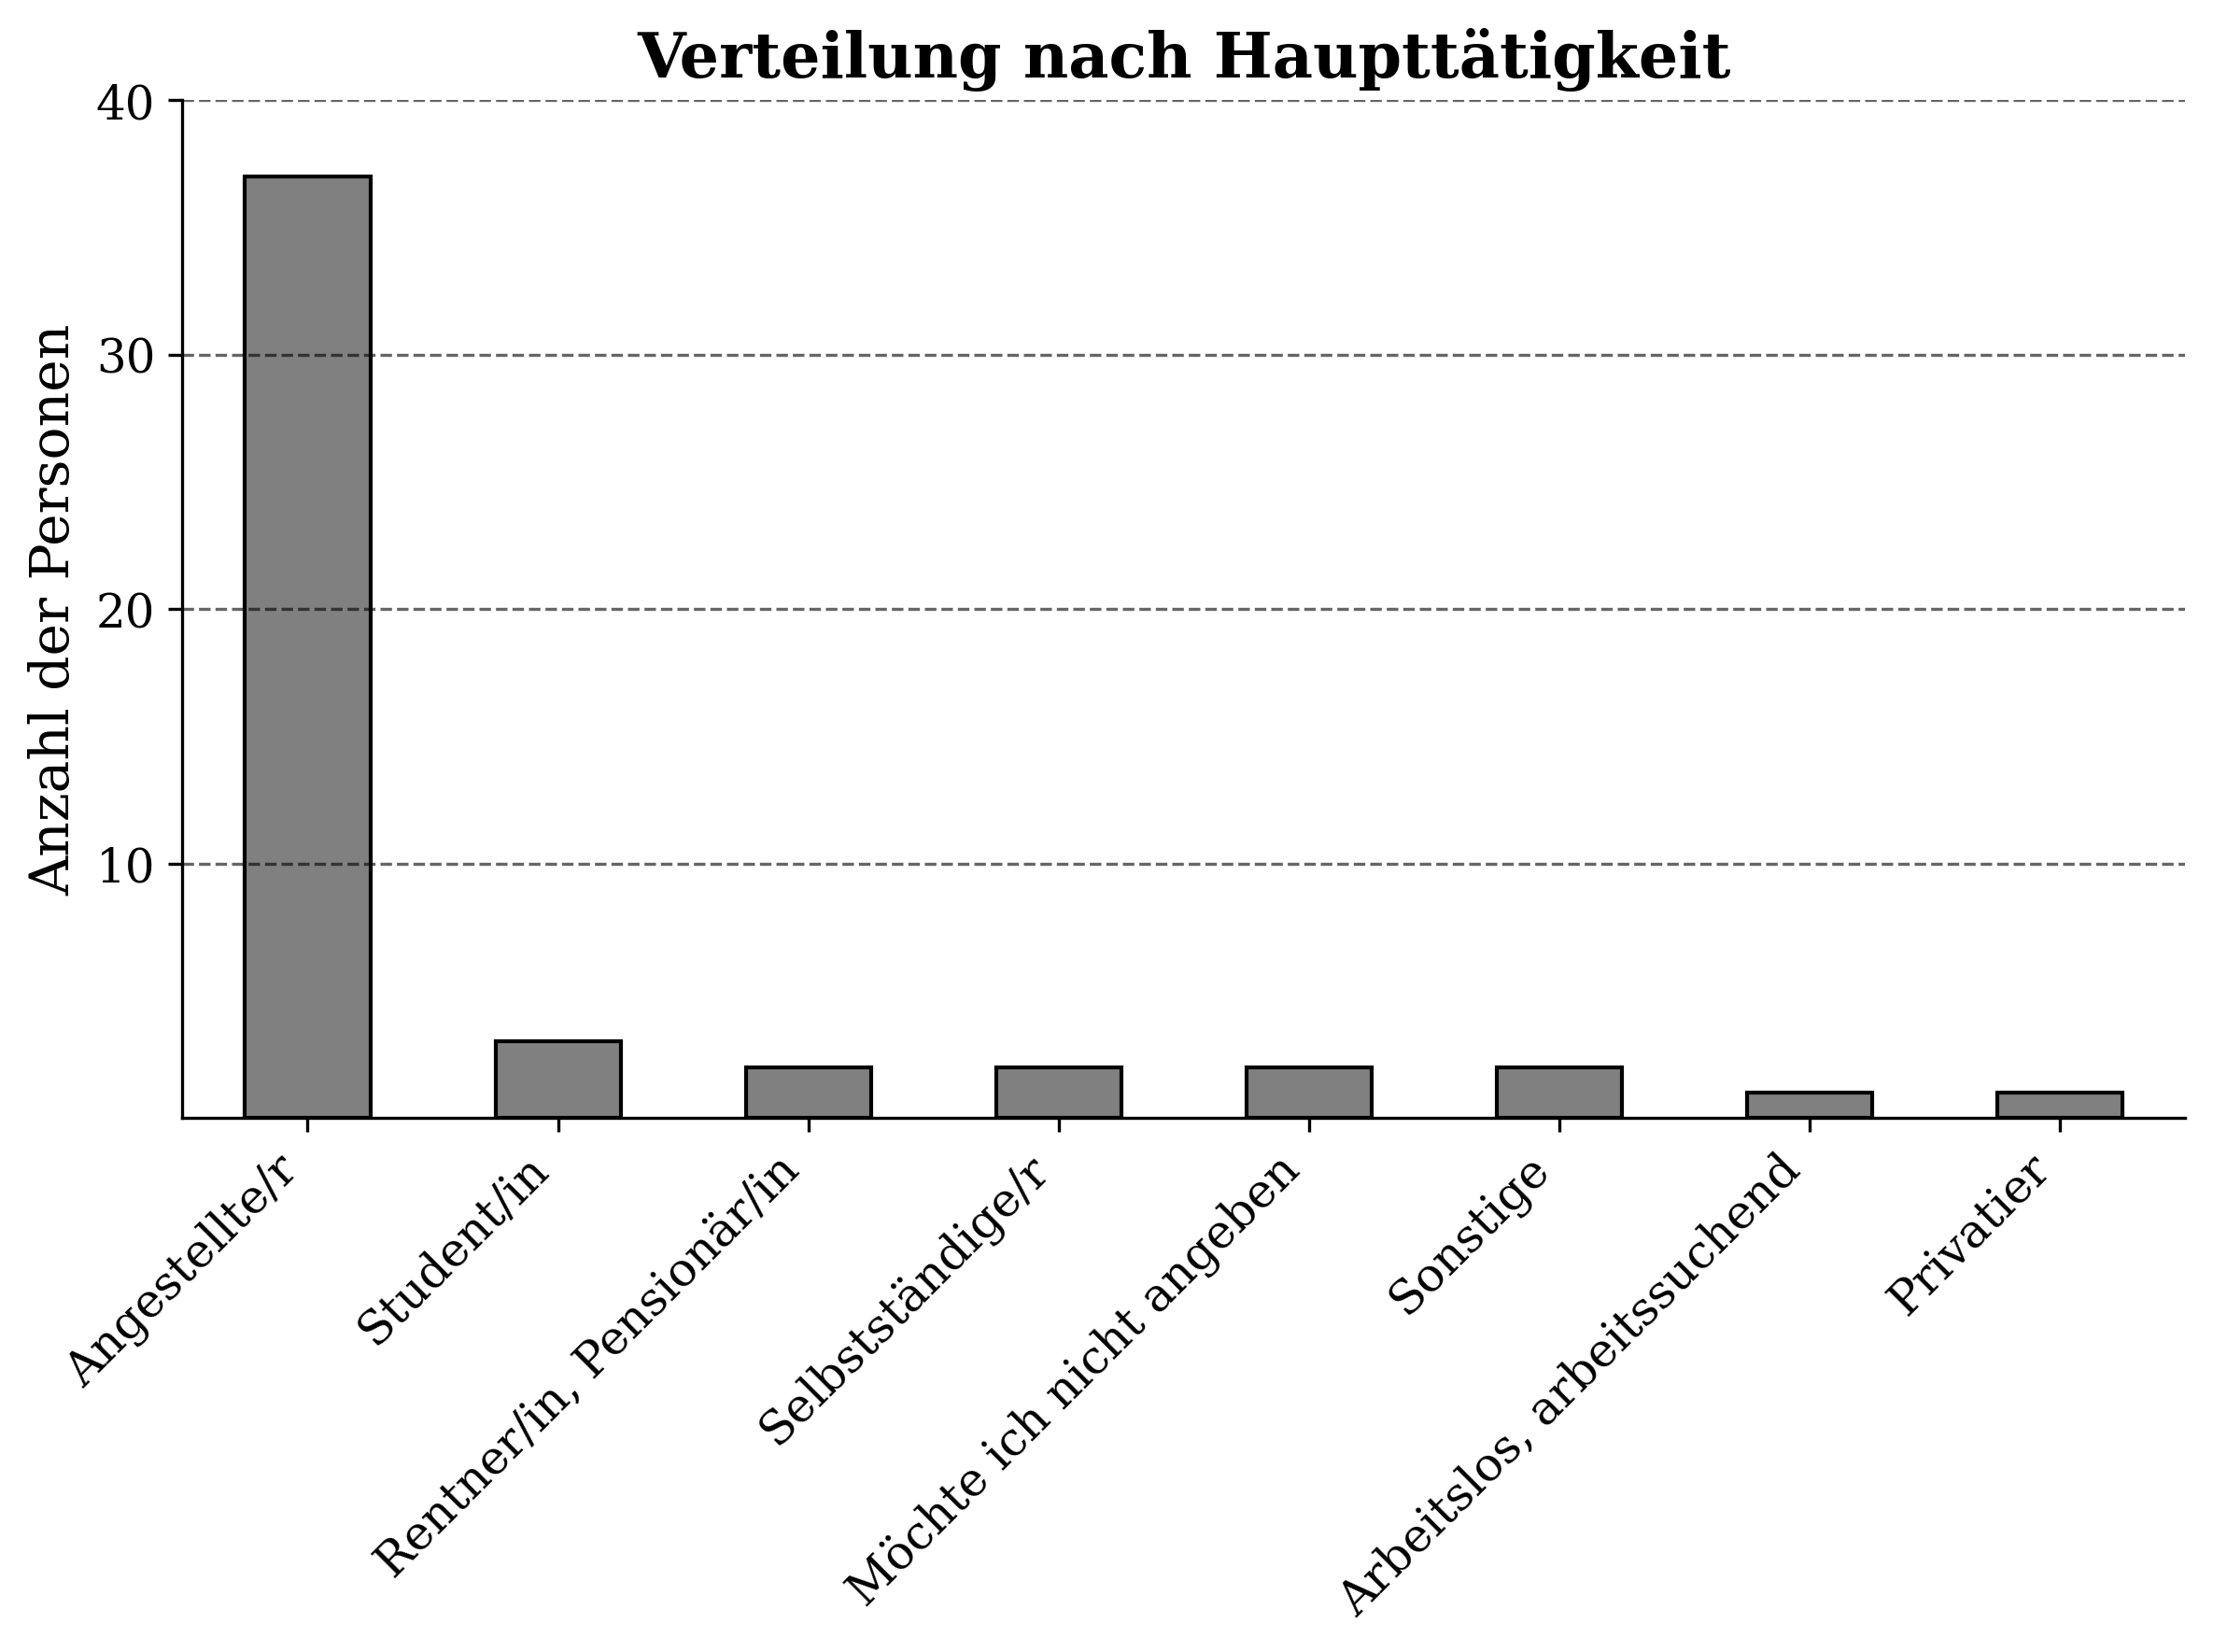

In [211]:
# Berechne die Häufigkeit der Antworten und ersetze im Plot das Label
haupttaetigkeit_counts = df['Was ist deine aktuelle Haupttätigkeit (trifft am ehesten zu)?'].value_counts(ascending=False)

# Ersetze das Label "Ich lebe von Einkünften aus Kapitalvermögen/Vermietungen/Verpachtungen" durch "Privatier"
haupttaetigkeit_counts.index = haupttaetigkeit_counts.index.str.replace(
    'Ich lebe von Einkünften aus Kapitalvermögen/Vermietungen/Verpachtungen', 'Privatier')

# Erstelle ein Balkendiagramm der Haupttätigkeitsverteilung ohne invertierte Achsen
plt.figure(figsize=(8, 6), dpi=300)
haupttaetigkeit_counts.plot(kind='bar', color='gray', edgecolor='black')  # 'bar' für vertikales Balkendiagramm
plt.title('Verteilung nach Haupttätigkeit', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('', fontsize=14, family='serif')
plt.ylabel('Anzahl der Personen', fontsize=14, family='serif')
plt.xticks(rotation=45, ha='right', fontsize=12, family='serif')  # Rotiert die X-Achsen-Beschriftungen
plt.yticks([10, 20, 30, 40], fontsize=12, family='serif')  # Setzt die Y-Achsen-Ticks auf 5, 10, 15, 20
plt.grid(axis='y', linestyle='--', alpha=0.6, color='black')  # Gitterlinien entlang der Y-Achse
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()  # Optimiert den Layout-Abstand
plt.show()


## Wie wohnst du

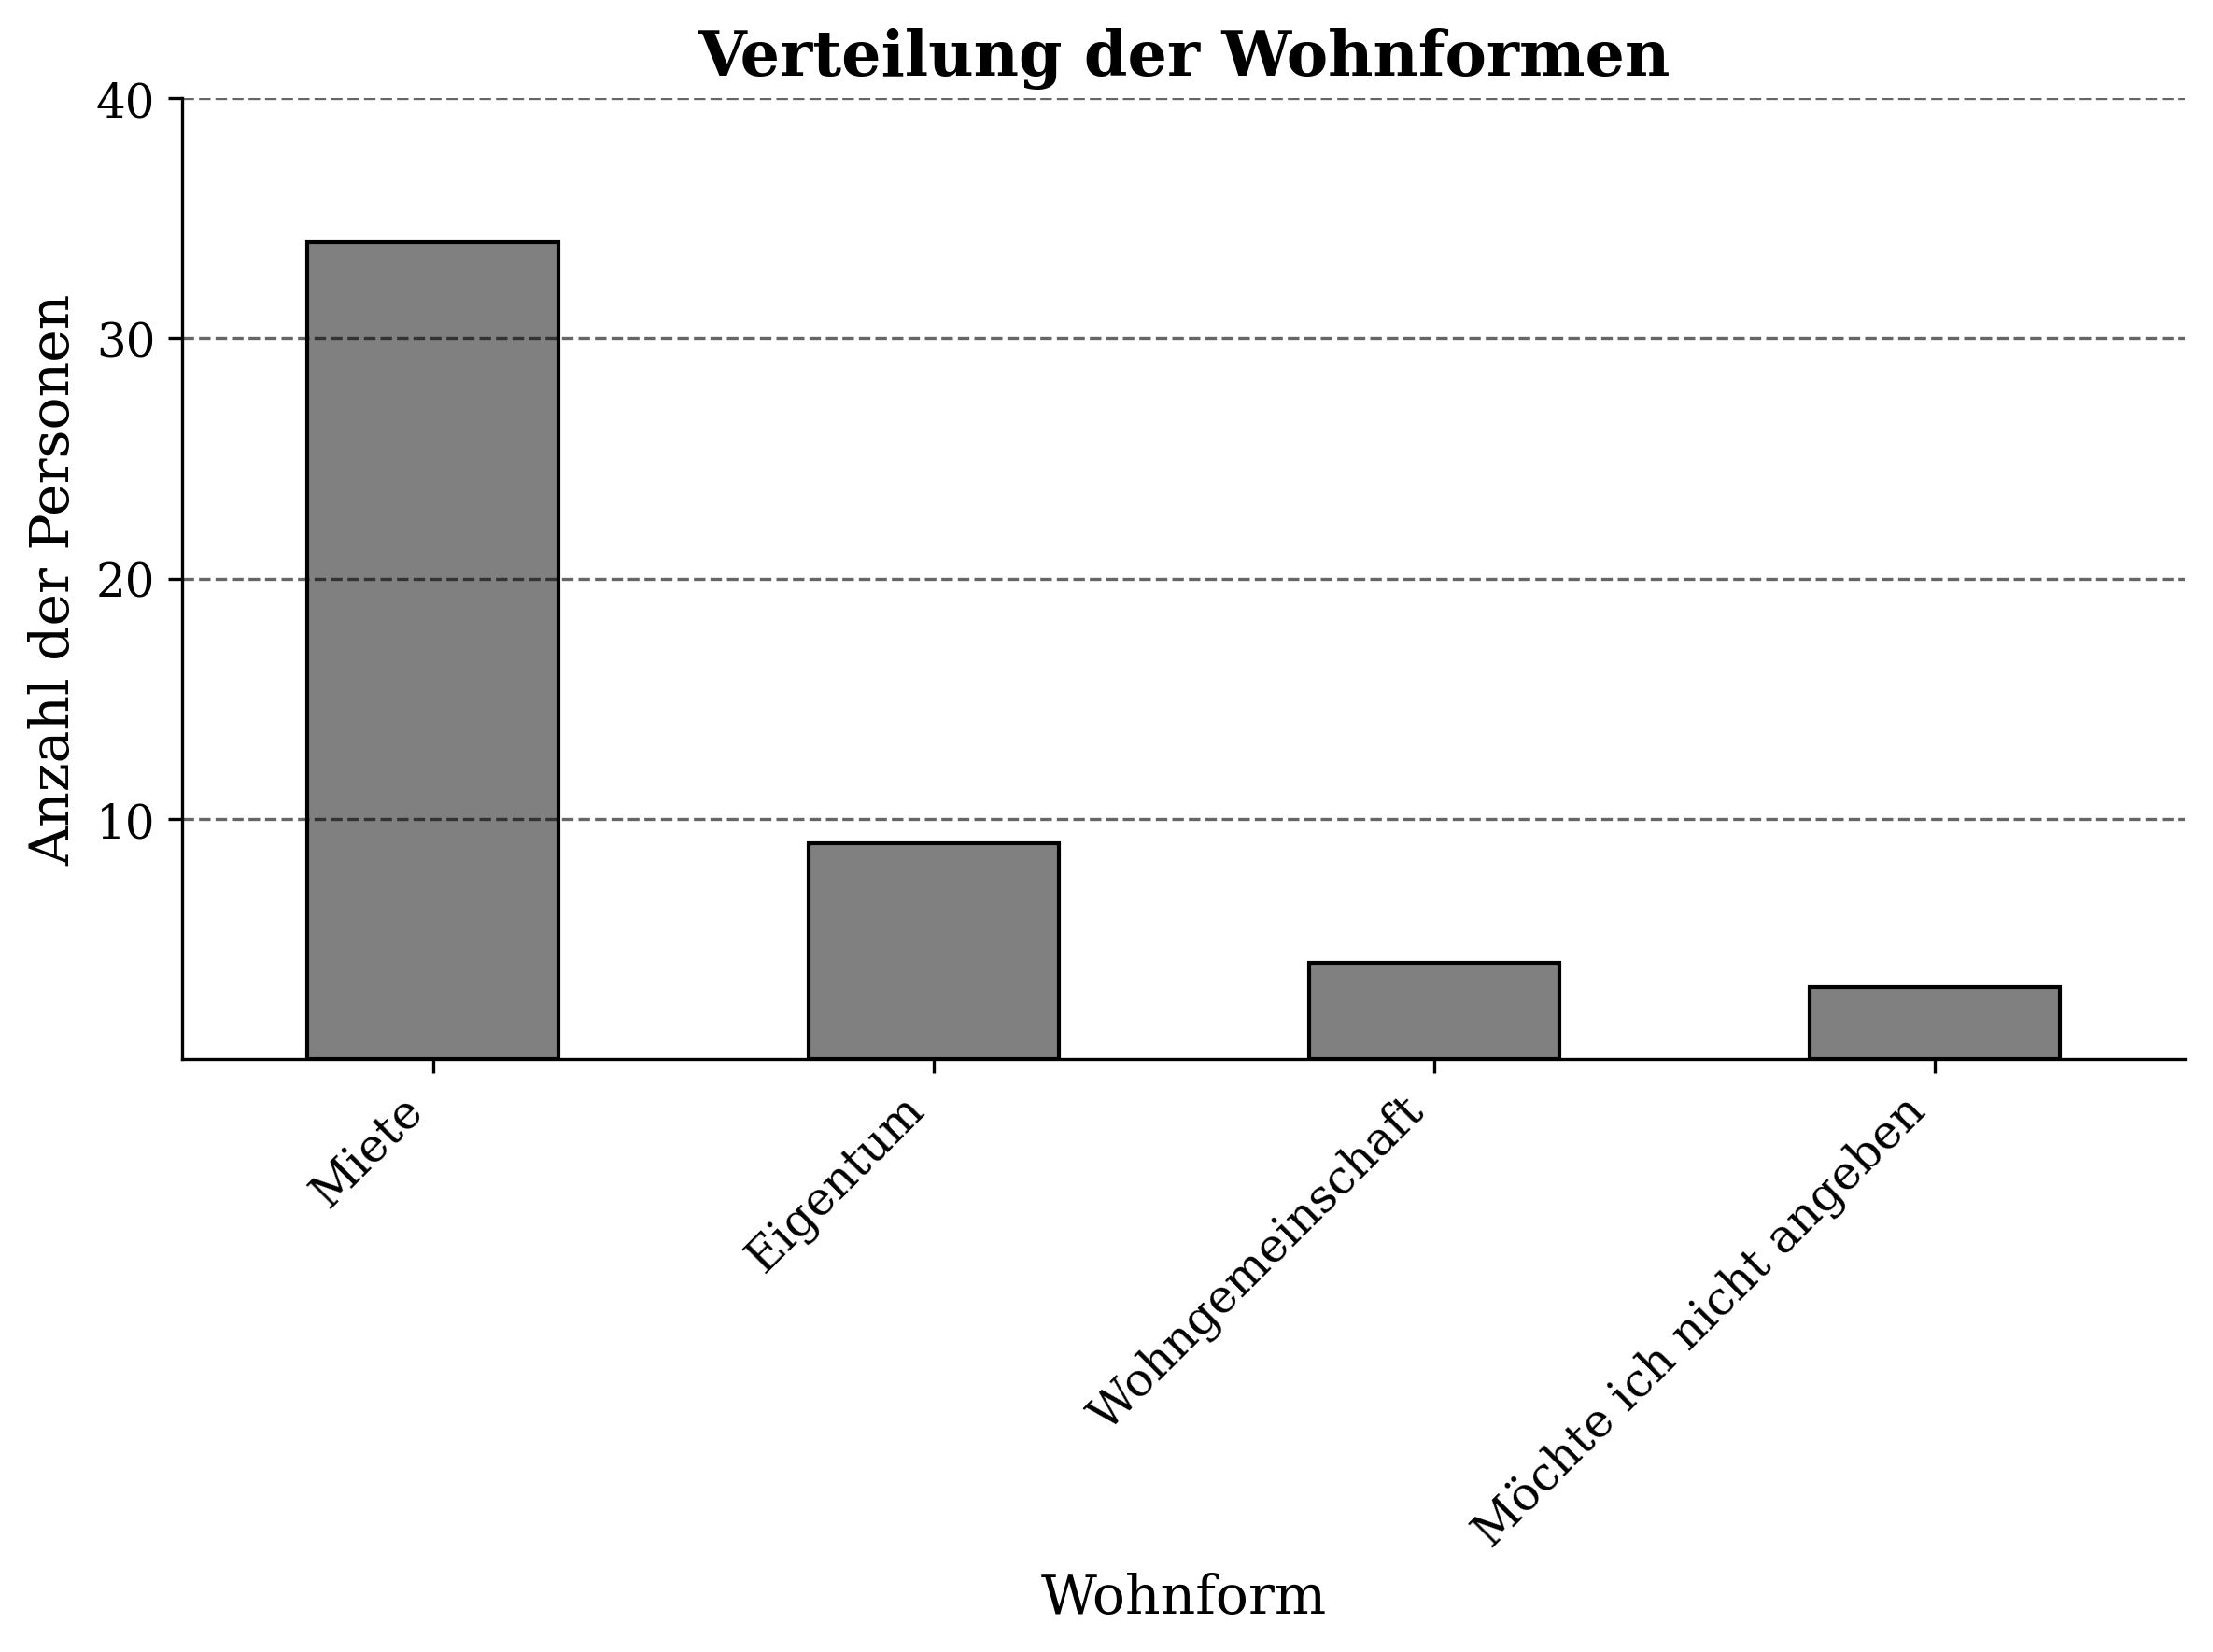

In [215]:
# Berechne die Häufigkeit der Antworten und sortiere sie in absteigender Reihenfolge
wohnform_counts = df['Wie wohnst du?'].value_counts(ascending=False)

# Erstelle ein Balkendiagramm der Wohnformenverteilung ohne invertierte Achsen und absteigender Sortierung
plt.figure(figsize=(8, 6), dpi=300)
wohnform_counts.plot(kind='bar', color='gray', edgecolor='black')  # 'bar' für vertikales Balkendiagramm
plt.title('Verteilung der Wohnformen', fontsize=16, fontweight='bold', family='serif')
plt.xlabel('Wohnform', fontsize=14, family='serif')
plt.ylabel('Anzahl der Personen', fontsize=14, family='serif')
plt.xticks(rotation=45, ha='right', fontsize=12, family='serif')  # Rotiert die X-Achsen-Beschriftungen
plt.yticks([10, 20, 30, 40], fontsize=12, family='serif')  # Setzt die Y-Achsen-Ticks auf 5, 10, 15, 20
plt.grid(axis='y', linestyle='--', alpha=0.6, color='black')  # Gitterlinien entlang der Y-Achse
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()  # Optimiert den Layout-Abstand
plt.show()
